In [4]:
import os
os.chdir("C:/Users/nicolas.grevet/Documents/SESSTIM/QuanTIM/Survie/Python_Scripts/TrajectoryClusteringAnalysis")

In [5]:
import TrajectoryClusteringAnalysis.tca as TCA

In [ ]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans



In [7]:
project_path = os.getcwd()
root_path = os.path.abspath(os.path.join(project_path, os.pardir))
file_path = os.path.join(root_path, 'TrajectoryClusteringAnalysis\data', 'vican_unidim_6months_TCA.xlsx')

# Check if the file exists
if os.path.exists(file_path):
	df = pd.read_excel(file_path)
	print(df.head())
else:
	print(f"File not found: {file_path}")

   ID_PATIENT       DATE  Months_Since_First_Events     Lib_traitement
0  1101100224 2010-04-01                          0          Chirurgie
1  1101100224 2010-05-10                          1  Chimiothérapie IV
2  1101100224 2010-06-17                          2  Chimiothérapie IV
3  1101100224 2010-07-01                          3  Chimiothérapie IV
4  1101100224 2010-08-19                          4  Chimiothérapie IV


In [8]:
# Sélectionner les colonnes pertinentes pour l'analyse
selected_cols = df[['ID_PATIENT', 'Months_Since_First_Events', 'Lib_traitement']]
# Créer un tableau croisé des données en format large
#       -> Chaque individu est sur une ligne.
#       -> Les mesures dans le temps (Temps1, Temps2, Temps3) sont des colonnes distinctes.
pivoted_data = selected_cols.pivot(index='ID_PATIENT', columns='Months_Since_First_Events', values='Lib_traitement')
pivoted_data['id'] = pivoted_data.index
pivoted_data = pivoted_data[['id'] + [col for col in pivoted_data.columns if col != 'id']]
# Renommer les colonnes avec un préfixe "month_"
pivoted_data.columns = ['id'] + ['month_' + str(int(col)+1) for col in pivoted_data.columns[1:]]
pivoted_data.head()

# Sélectionner un échantillon aléatoire de 10% des données
# pivoted_data_random_sample = pivoted_data.sample(frac=0.1, random_state=42).reset_index(drop=True)
# pivoted_data_random_sample

,id,month_1,month_2,month_3,month_4,month_5,month_6,month_7
ID_PATIENT,,,,,,,,
1101100224,1101100224,Chirurgie,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV
1101105979,1101105979,Chirurgie,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV
1101106819,1101106819,Chimiothérapie per os,Radiothérapie,NaN,NaN,NaN,Chimiothérapie IV,Chimiothérapie IV
1101107369,1101107369,Chirurgie,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,NaN,NaN,NaN
1101108956,1101108956,Chirurgie,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV


In [52]:
alphabet_mapping = {
    'Chimiothérapie IV': 'CIV',
    'Chimiothérapie per os': 'Cos',
    'Chirurgie': 'Chi',
    'Radiothérapie': 'Rad'
}

mapped_pivoted_data = pivoted_data.replace(alphabet_mapping)
mapped_pivoted_data.drop(columns=['month_7'], inplace=True)
mapped_pivoted_data.head()

,id,month_1,month_2,month_3,month_4,month_5,month_6
ID_PATIENT,,,,,,,
1101100224,1101100224,Chi,CIV,CIV,CIV,CIV,CIV
1101105979,1101105979,Chi,CIV,CIV,CIV,CIV,CIV
1101106819,1101106819,Cos,Rad,NaN,NaN,NaN,CIV
1101107369,1101107369,Chi,CIV,CIV,CIV,NaN,NaN
1101108956,1101108956,Chi,CIV,CIV,CIV,CIV,CIV


### KMeans

In [20]:
label_encoder = LabelEncoder()
encoded_values = label_encoder.fit_transform(mapped_pivoted_data.iloc[:, 1:].values.flatten())
encoded_matrix = encoded_values.reshape(mapped_pivoted_data.iloc[:, 1:].shape)

pca = PCA(n_components=2) 
pca_result = pca.fit_transform(encoded_matrix)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [2, 3, 4, ..., 4, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 4, 4],
       [0, 0, 0, ..., 4, 4, 4]])

c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.6441735563781715


c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.6112232285024948


c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.6443396577427671


c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.6640535379941994


c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.6789486586268392


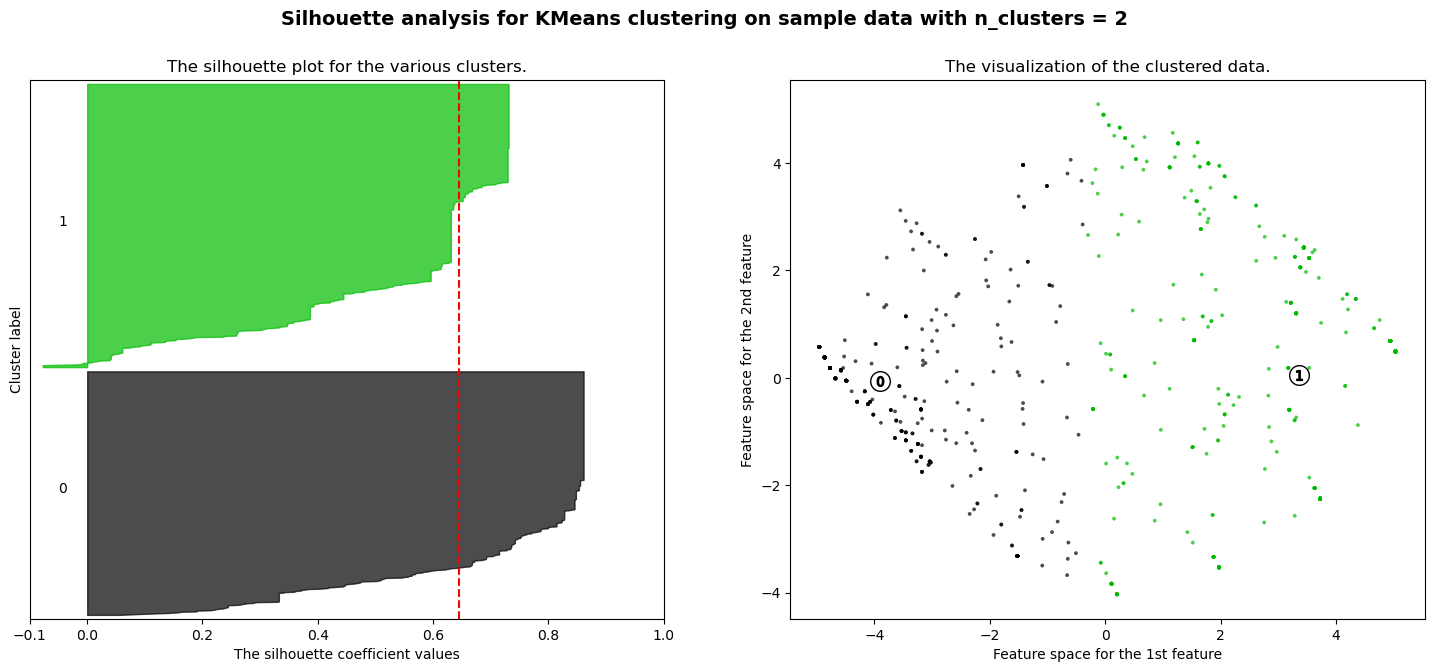

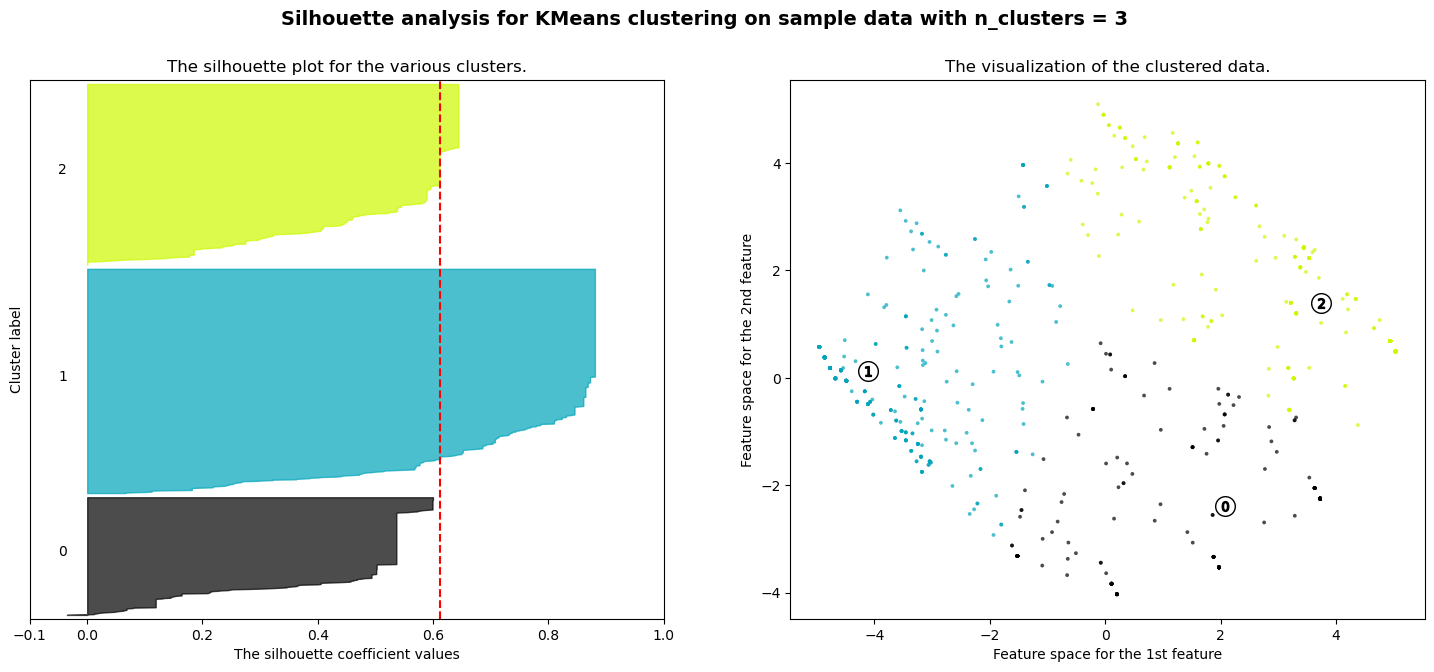

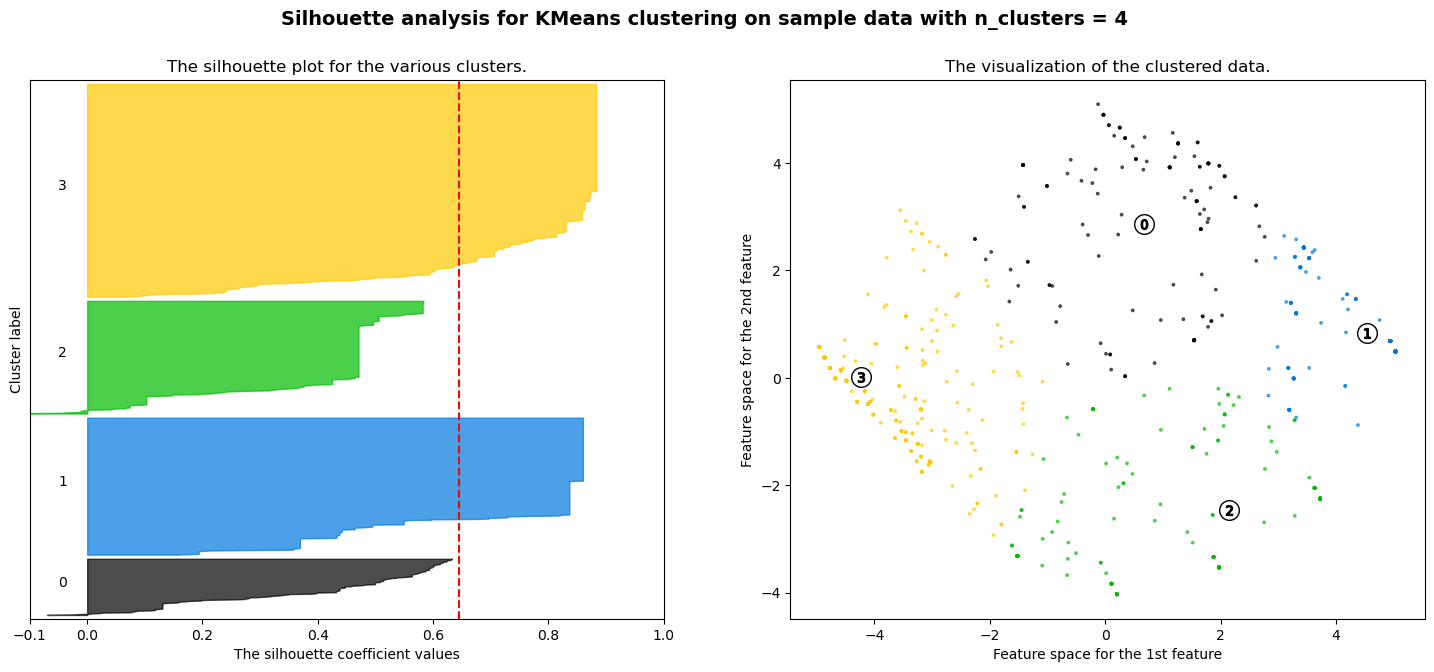

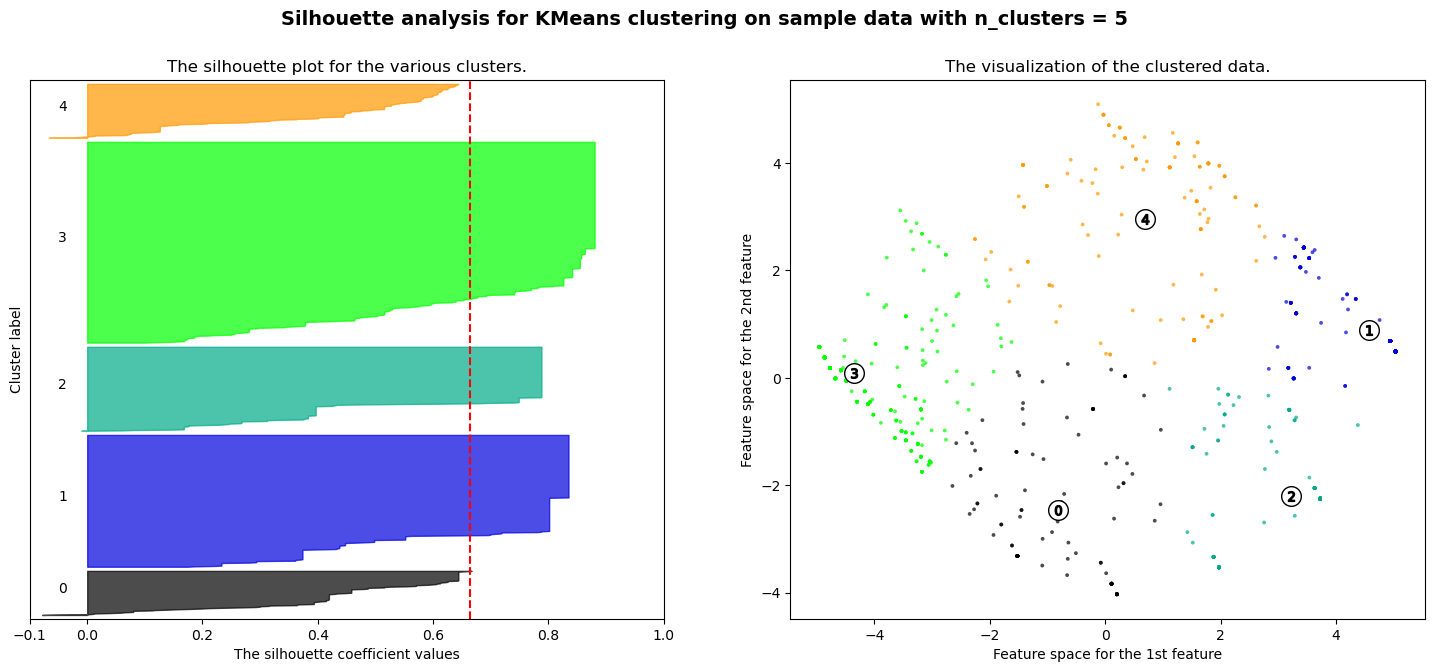

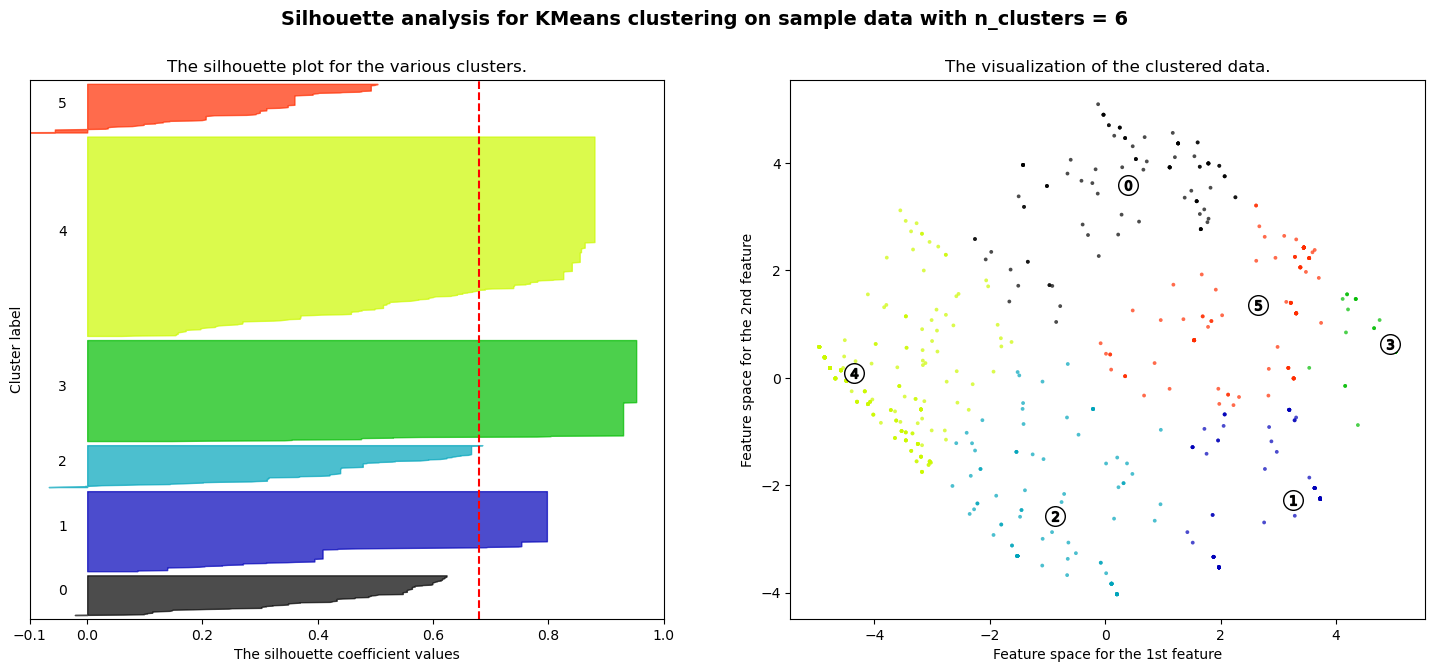

In [26]:
X = pca_result

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca_result[:, 0], pca_result[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6435443050577766
For n_clusters = 3 The average silhouette_score is : 0.5670076639106809
For n_clusters = 4 The average silhouette_score is : 0.5670076639106809


c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.6086258285359099
For n_clusters = 6 The average silhouette_score is : 0.6332055647185734


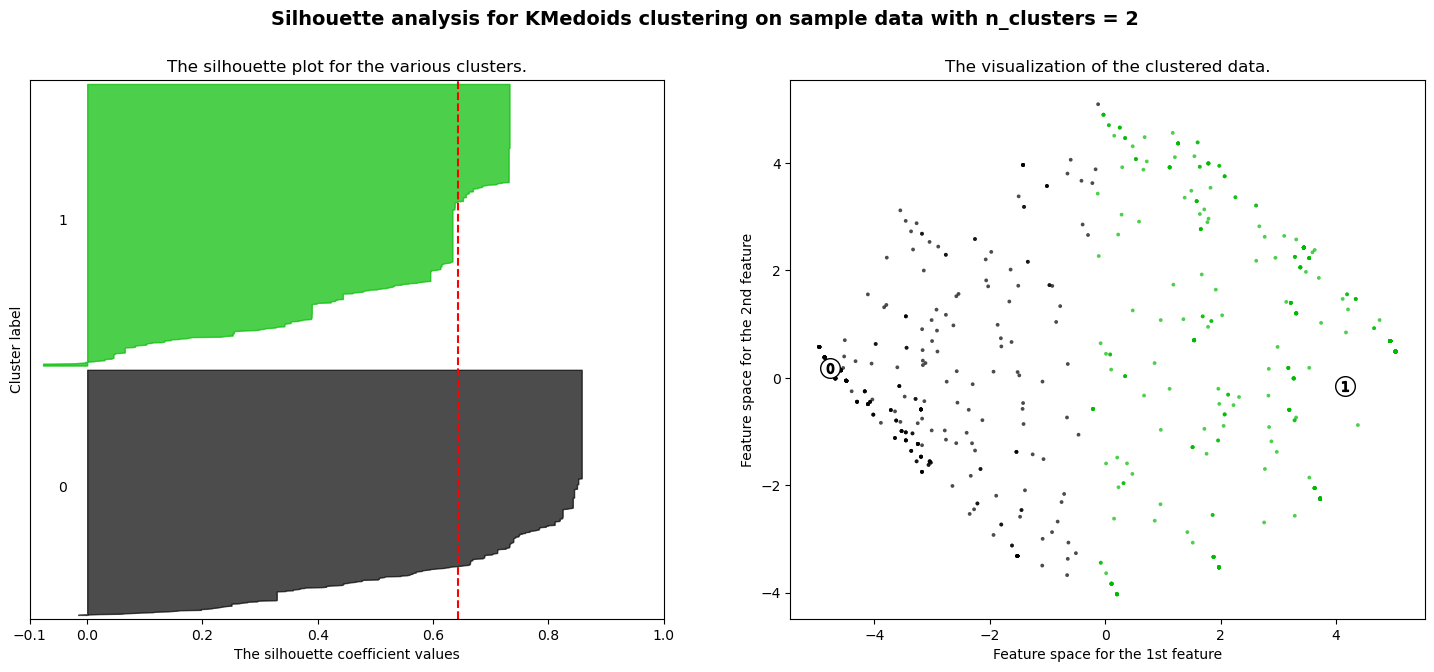

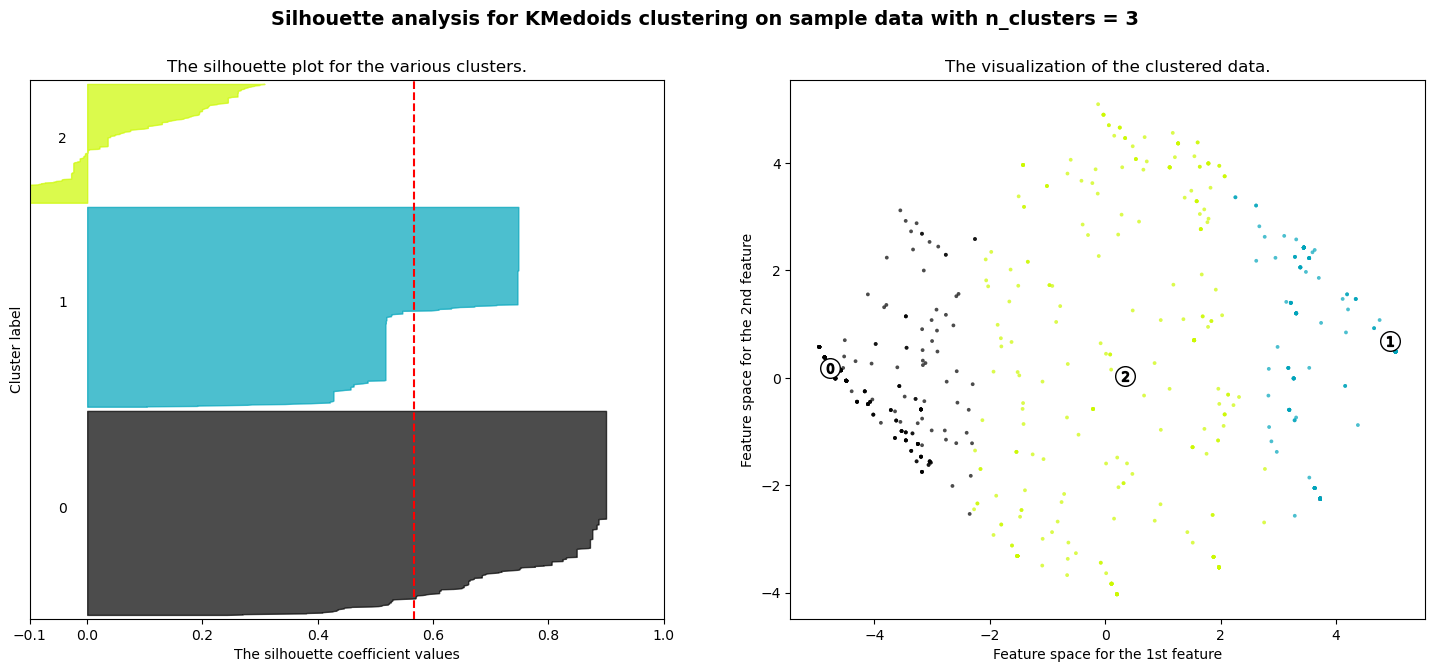

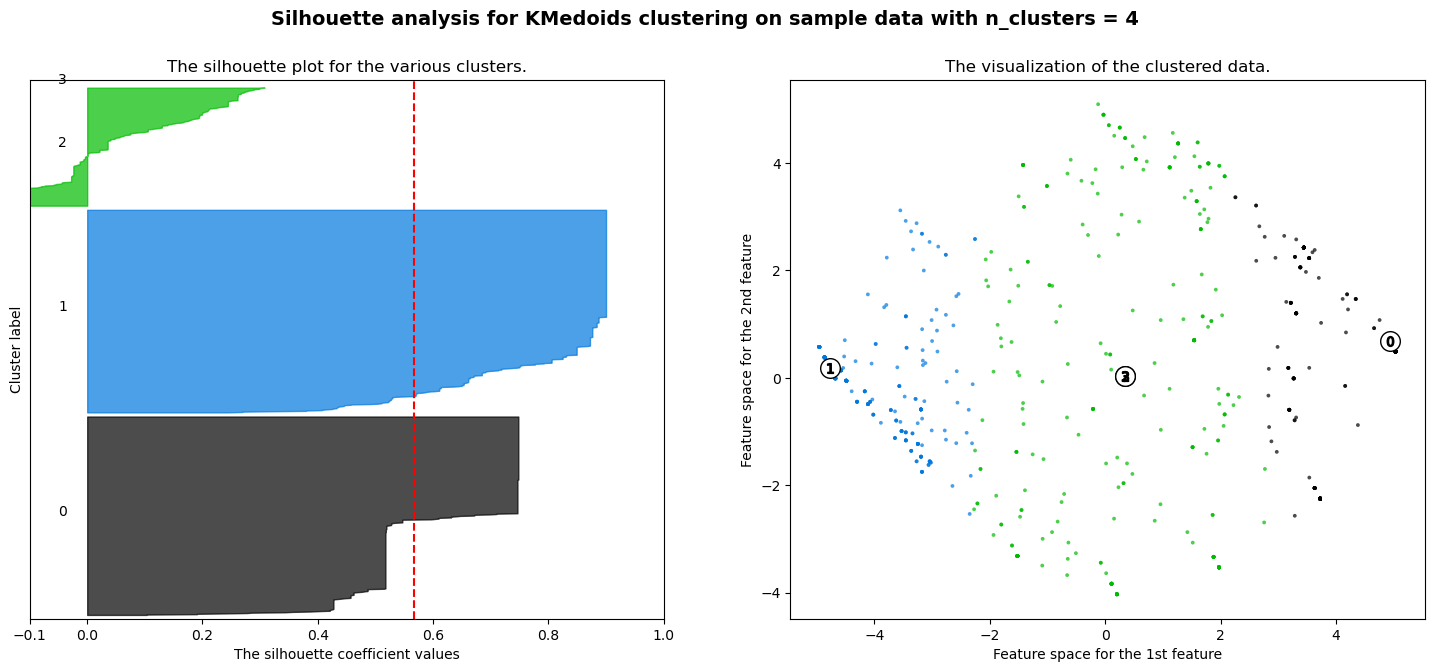

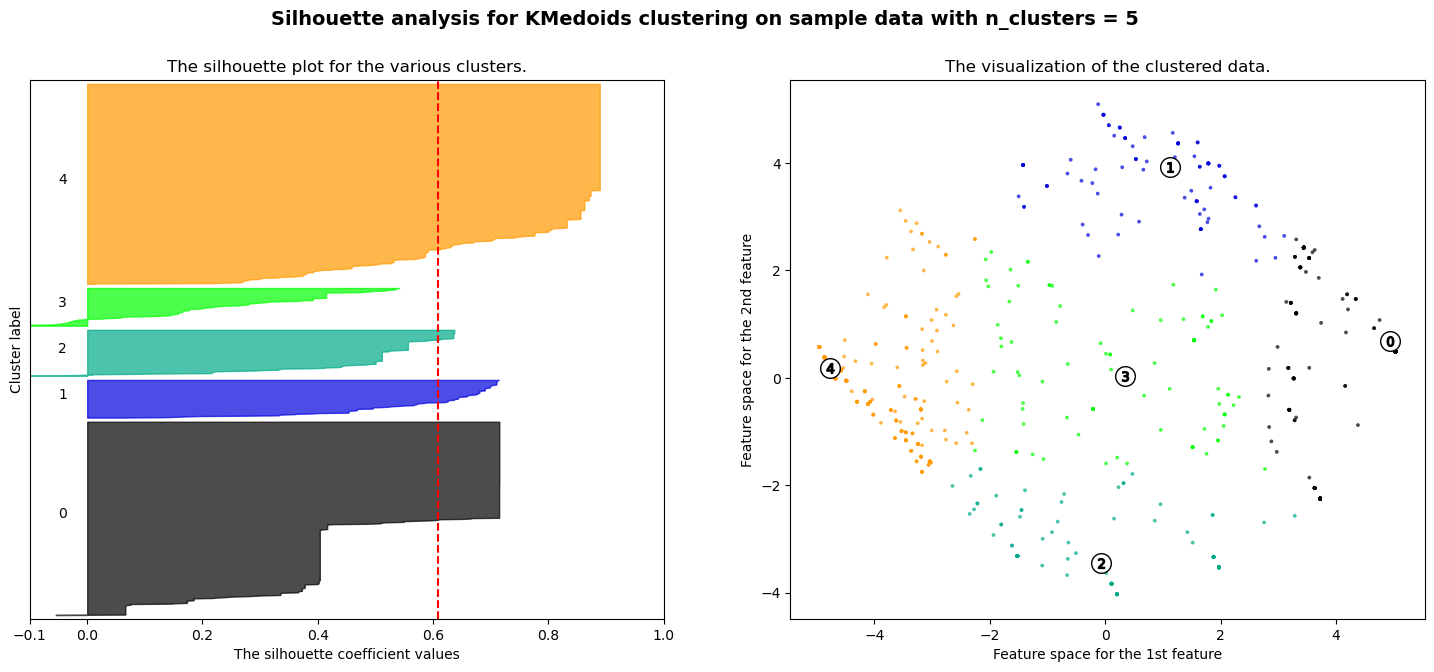

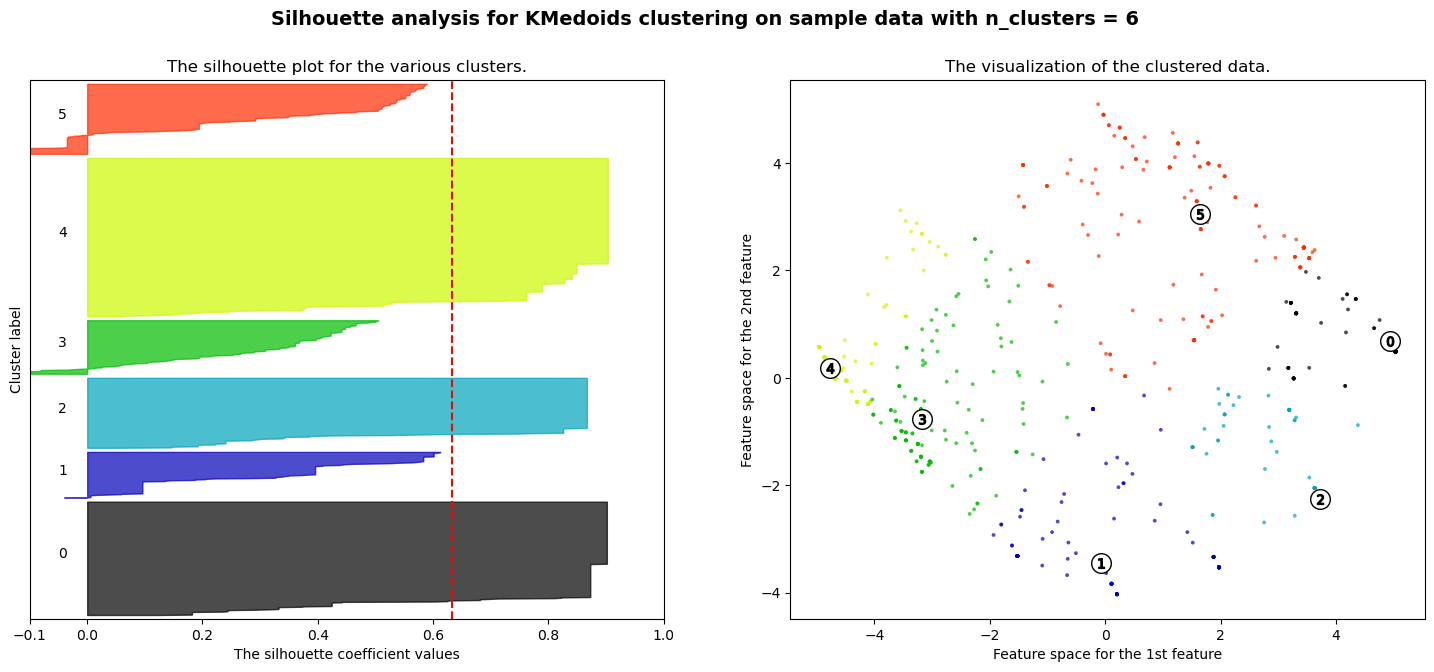

In [156]:
from sklearn_extra.cluster import KMedoids

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the KMedoids clusterer
    clusterer = KMedoids(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca_result[:, 0], pca_result[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMedoids clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [34]:
# Ensure that TCA refers to the correct class or function within the module
tca = TCA.TCA(data=mapped_pivoted_data,
              id='id',
              alphabet=['CIV', 'Cos', 'Chi', 'Rad'],
              states=['Chimiothérapie IV', 'Chimiothérapie per os', 'Chirurgie', 'Radiothérapie'])

INFO:root:TCA object initialized successfully


Dataset :
data shape:  (1371, 8)
state coding:
   alphabet                  label  label encoded
0      CIV      Chimiothérapie IV              1
1      Cos  Chimiothérapie per os              2
2      Chi              Chirurgie              3
3      Rad          Radiothérapie              4


In [35]:
distance_matrix = tca.compute_distance_matrix(metric='dtw', substitution_cost_matrix=None)
print("distance matrix :\n",distance_matrix)

INFO:root:Calculating distance matrix using metric: dtw...
100%|██████████| 1371/1371 [00:46<00:00, 29.76it/s] 
INFO:root:Time taken for computation: 46.08 seconds


distance matrix :
 [[0.         0.         0.20203051 ... 0.         0.28571429 0.28571429]
 [0.         0.         0.20203051 ... 0.         0.28571429 0.28571429]
 [0.20203051 0.20203051 0.         ... 0.20203051 0.63245553 0.79056942]
 ...
 [0.         0.         0.20203051 ... 0.         0.28571429 0.28571429]
 [0.28571429 0.28571429 0.63245553 ... 0.28571429 0.         0.        ]
 [0.28571429 0.28571429 0.79056942 ... 0.28571429 0.         0.        ]]


In [ ]:
# custom_costs = {'CIV:Cos':1, 'CIV:Chi':2, 'CIV:Rad':3,
#                 'Cos:Chi':2, 'Cos:Rad':1,
#                 'Chi:Rad':10}  

# substitution_cost_matrix=tca.compute_substitution_cost_matrix(method='constant', custom_costs=None)
# substitution_cost_matrix

# distance_matrix = tca.compute_distance_matrix(metric='optimal_matching', substitution_cost_matrix=substitution_cost_matrix)
# print("distance matrix :\n",distance_matrix)

INFO:root:Computing the linkage matrix using method: ward...
INFO:root:Linkage matrix computed successfully


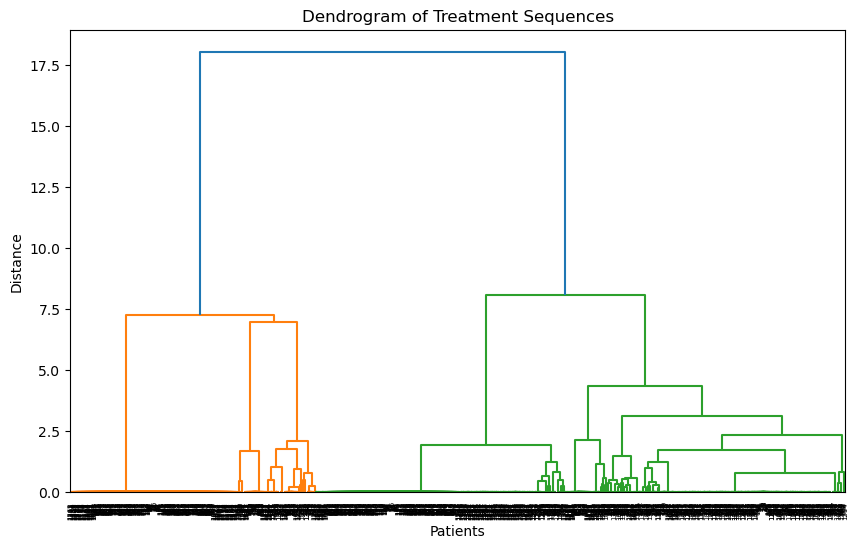

In [37]:
linkage_matrix = tca.hierarchical_clustering(distance_matrix)
tca.plot_dendrogram(linkage_matrix)

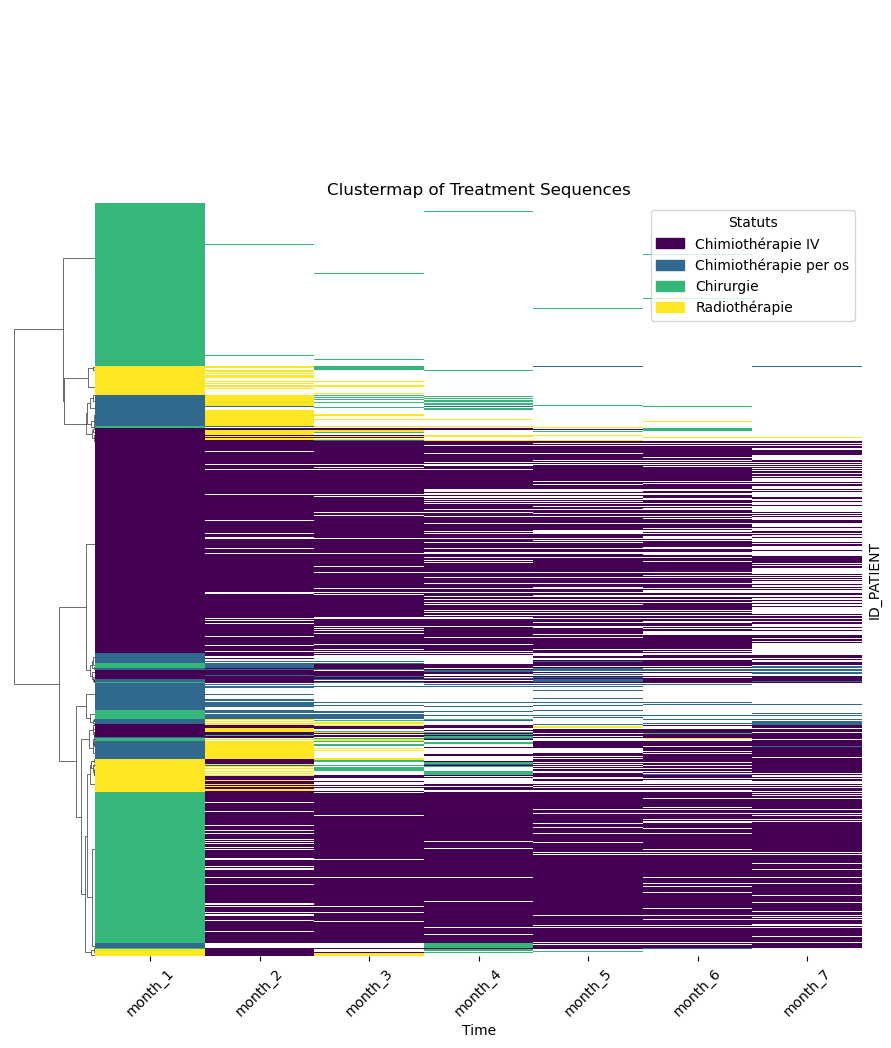

In [38]:
tca.plot_clustermap(linkage_matrix)

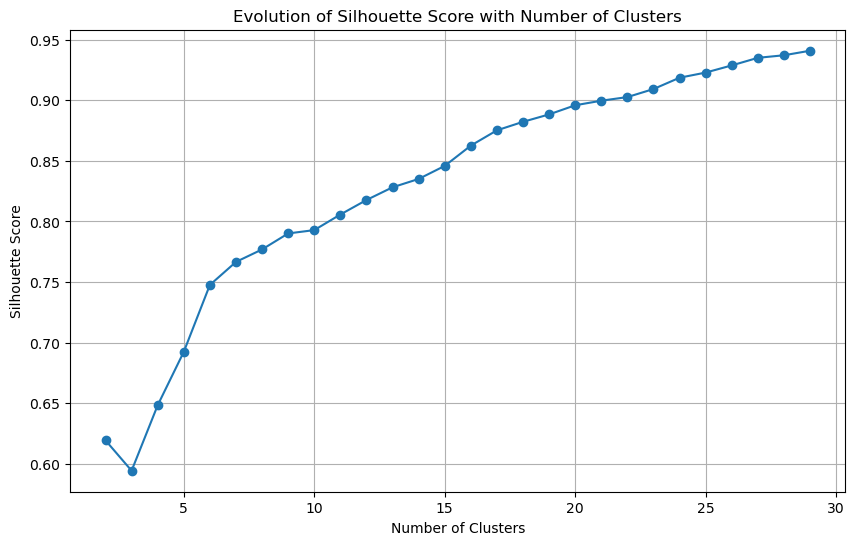

In [39]:
range_n_clusters = range(2, 30)
silhouette_scores = []

for n_clusters in range_n_clusters:
    cluster_labels = tca.assign_clusters(linkage_matrix, num_clusters=n_clusters)
    score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Evolution of Silhouette Score with Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

The active selection uses the silhouette_score function from the sklearn.metrics module to compute the mean silhouette coefficient for a clustering result. The silhouette coefficient is a metric that evaluates how well each data point fits within its assigned cluster compared to other clusters. 

It is calculated using two key distances for each sample: the mean intra-cluster distance (a), which measures how close the sample is to other points in the same cluster, and the mean nearest-cluster distance (b), which measures the distance between the sample and the nearest cluster it does not belong to. The silhouette coefficient for a sample is then computed as (b - a) / max(a, b). This value ranges from -1 to 1, where higher values indicate better-defined clusters, values near 0 suggest overlapping clusters, and negative values imply that the sample may have been misclassified.

In the active selection, the silhouette_score function is called with two arguments: distance_matrix and clusters. The distance_matrix is expected to be a precomputed matrix of pairwise distances between samples, and the clusters argument contains the predicted cluster labels for each sample. By default, the function assumes the metric is "precomputed" when a distance matrix is provided. The function then calculates the silhouette coefficient for each sample and returns the mean value across all samples, providing a single score that summarizes the quality of the clustering.

This metric is particularly useful for evaluating clustering algorithms because it does not require ground truth labels. Instead, it relies solely on the structure of the data and the clustering result. However, it is important to note that the silhouette score is only defined when there are at least two clusters and fewer clusters than the number of samples. Additionally, the quality of the score depends on the choice of distance metric and the clustering algorithm used.

For n_clusters = 4 The silhouette_score is : 0.6483215081698422


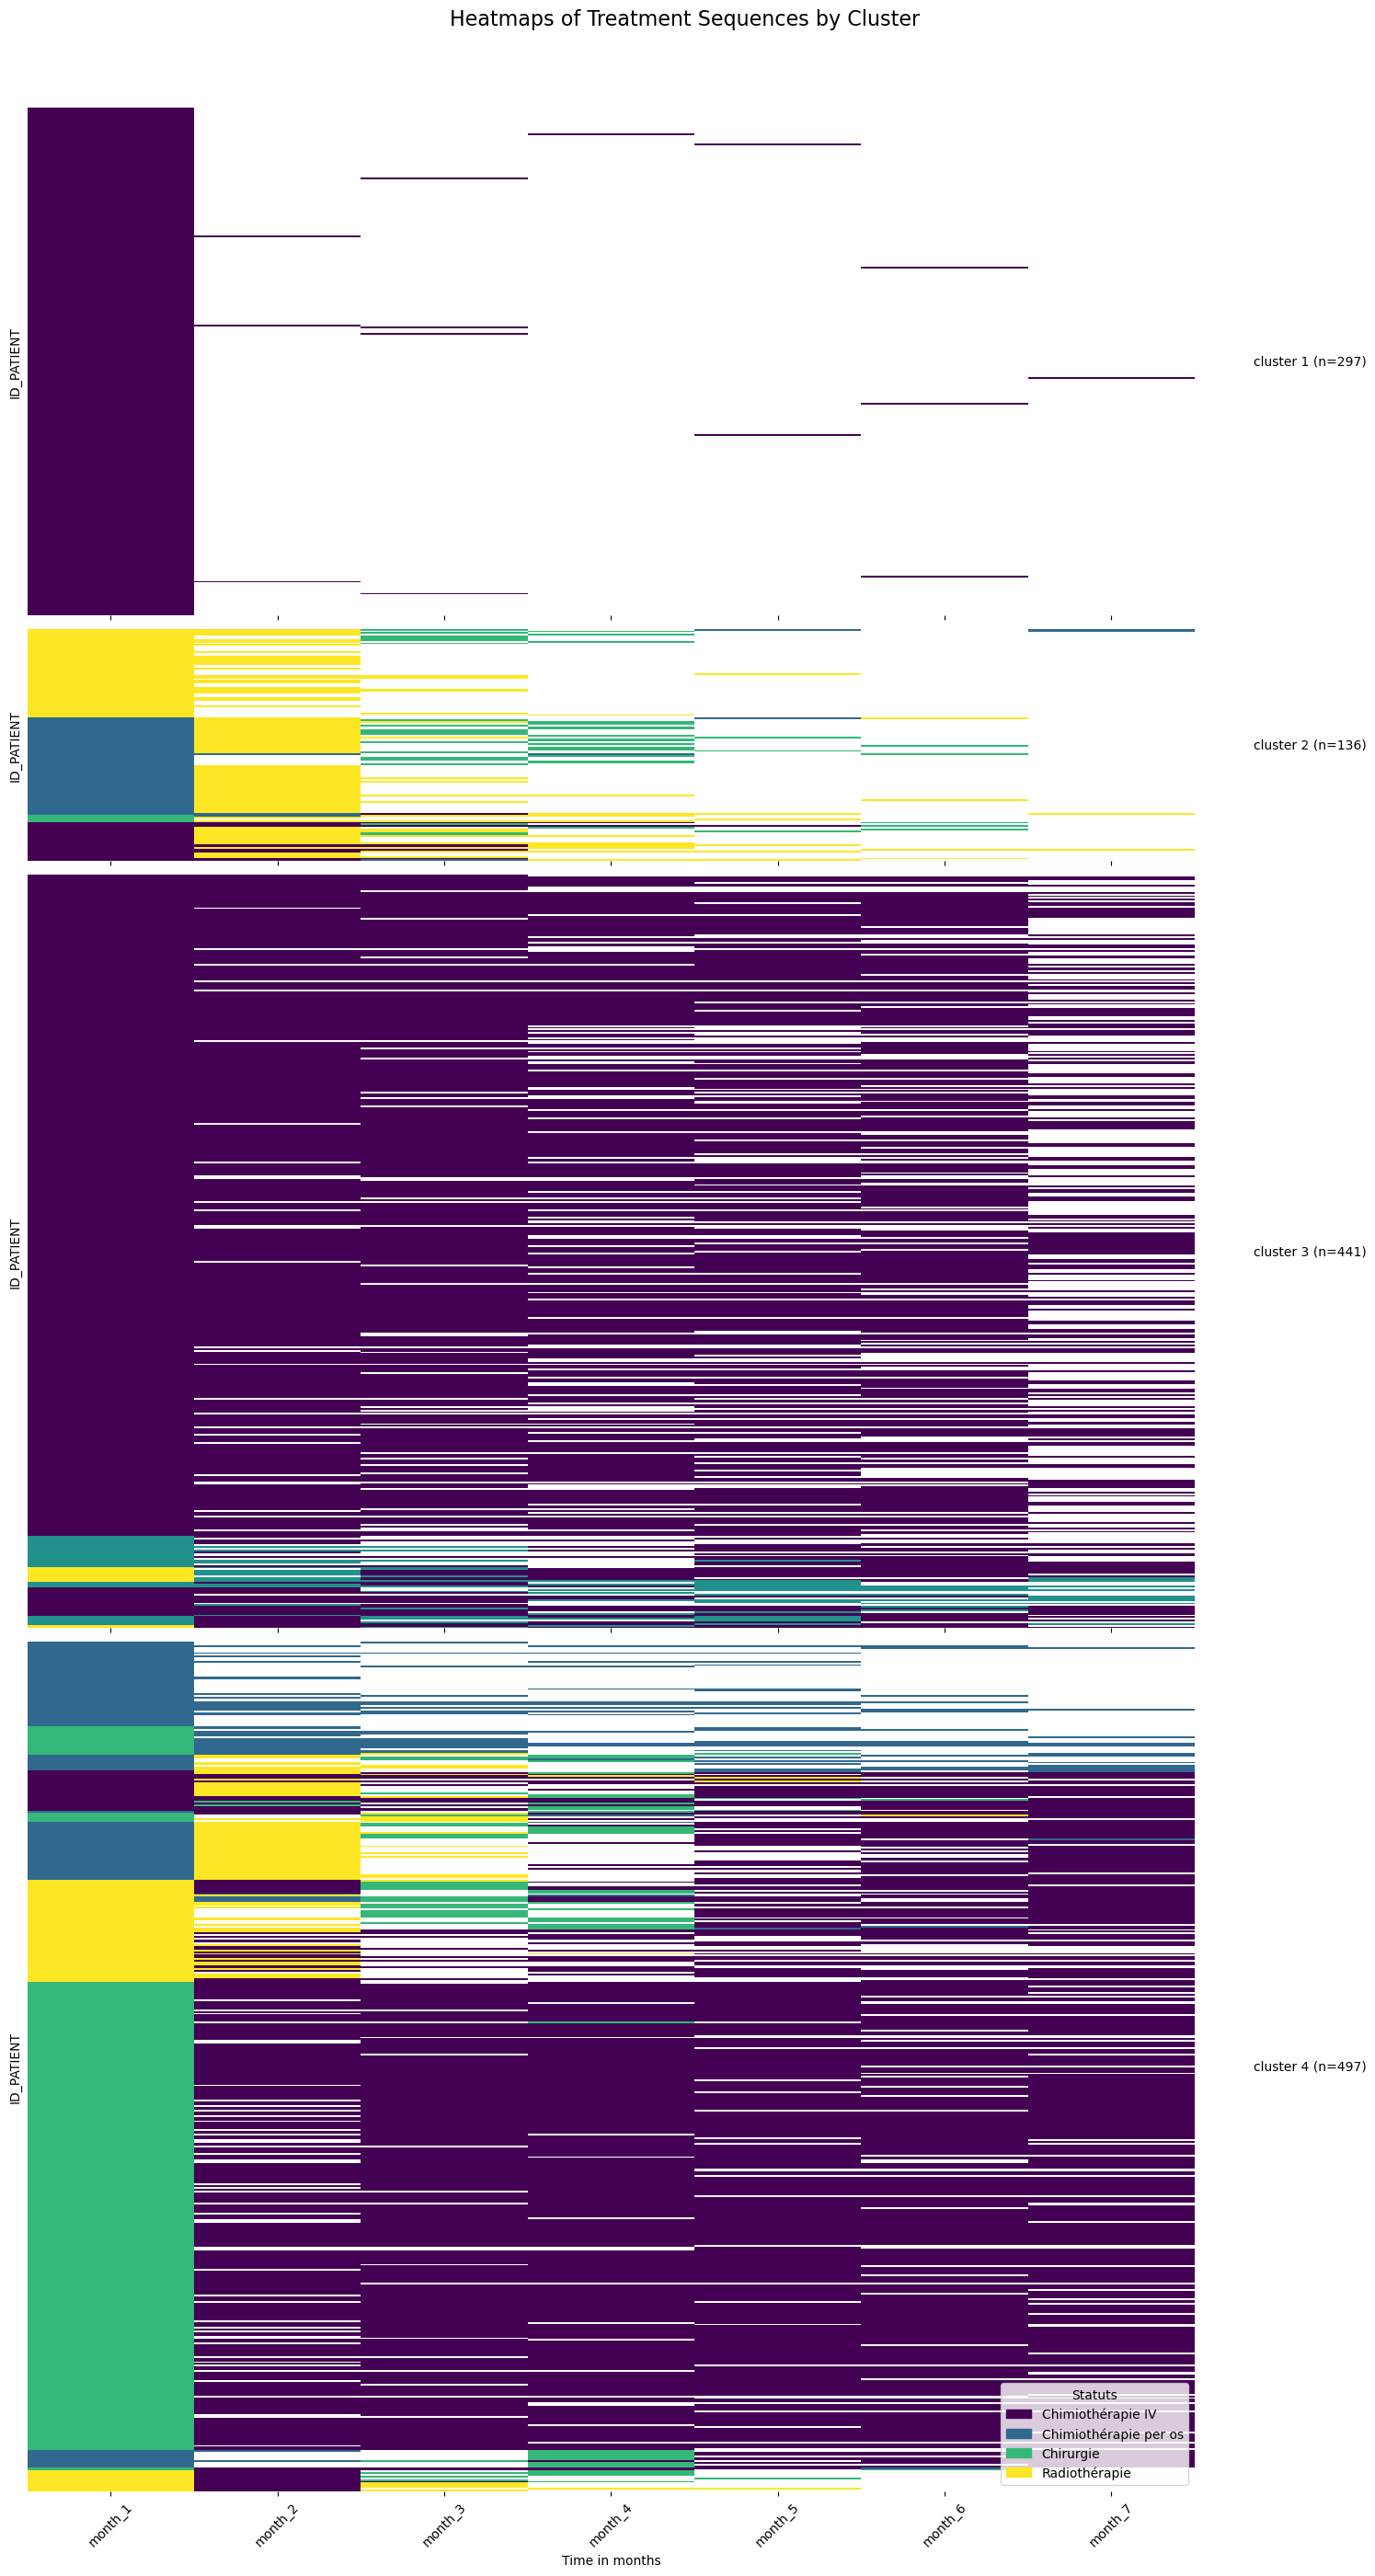

In [40]:
k = 4  # Number of clusters to use for the final clustering
clusters = tca.assign_clusters(linkage_matrix, num_clusters=k)
print("For n_clusters =", k, "The silhouette_score is :", silhouette_score(distance_matrix, clusters, metric='precomputed'))
tca.plot_cluster_heatmaps(clusters, sorted=False)

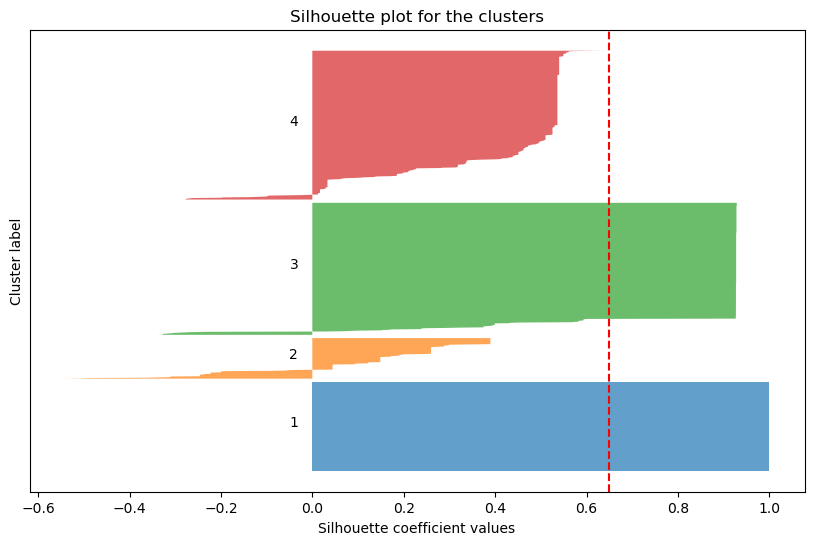

In [41]:
# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(distance_matrix, clusters, metric='precomputed')

# Plot silhouette scores for each cluster
plt.figure(figsize=(10, 6))
y_lower = 10
for i in np.unique(clusters):
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples gap

plt.title('Silhouette plot for the clusters')
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster label')
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.yticks([])
plt.show()

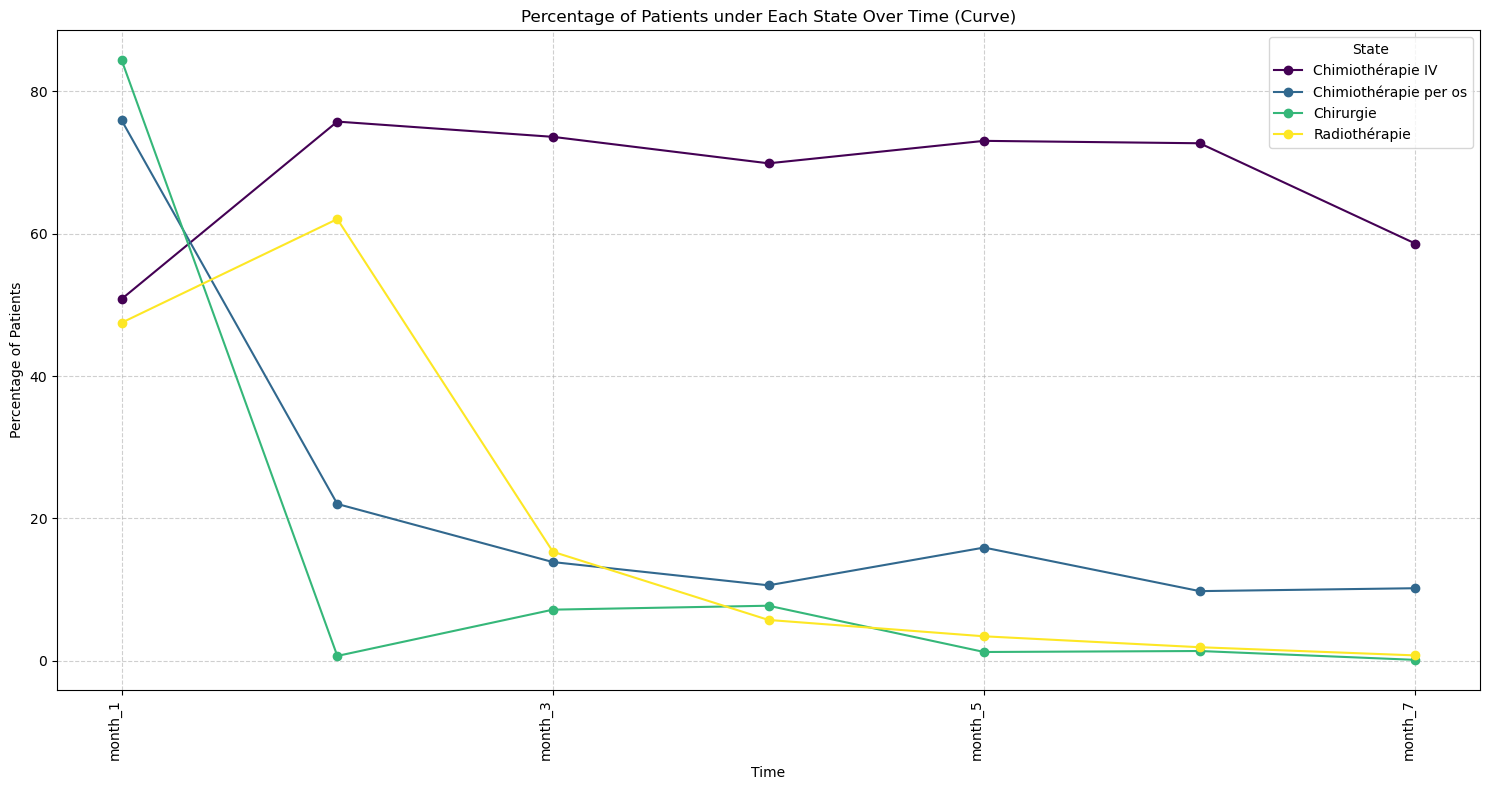

In [42]:
tca.plot_treatment_percentage()

In [132]:
data=mapped_pivoted_data
id_col='id'
alphabet=['CIV', 'Cos', 'Chi', 'Rad']
states=['Chimiothérapie IV', 'Chimiothérapie per os', 'Chirurgie', 'Radiothérapie']
viridis_colors_list = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(alphabet))]
color_mapping = dict(zip(alphabet, viridis_colors_list))

df = data.drop(id_col, axis=1).copy()
care_status_counts = df.apply(pd.Series.value_counts).fillna(0)

status_counts = care_status_counts.T

In [133]:
alphabet_mapping

{'Chimiothérapie IV': 'CIV',
 'Chimiothérapie per os': 'Cos',
 'Chirurgie': 'Chi',
 'Radiothérapie': 'Rad'}

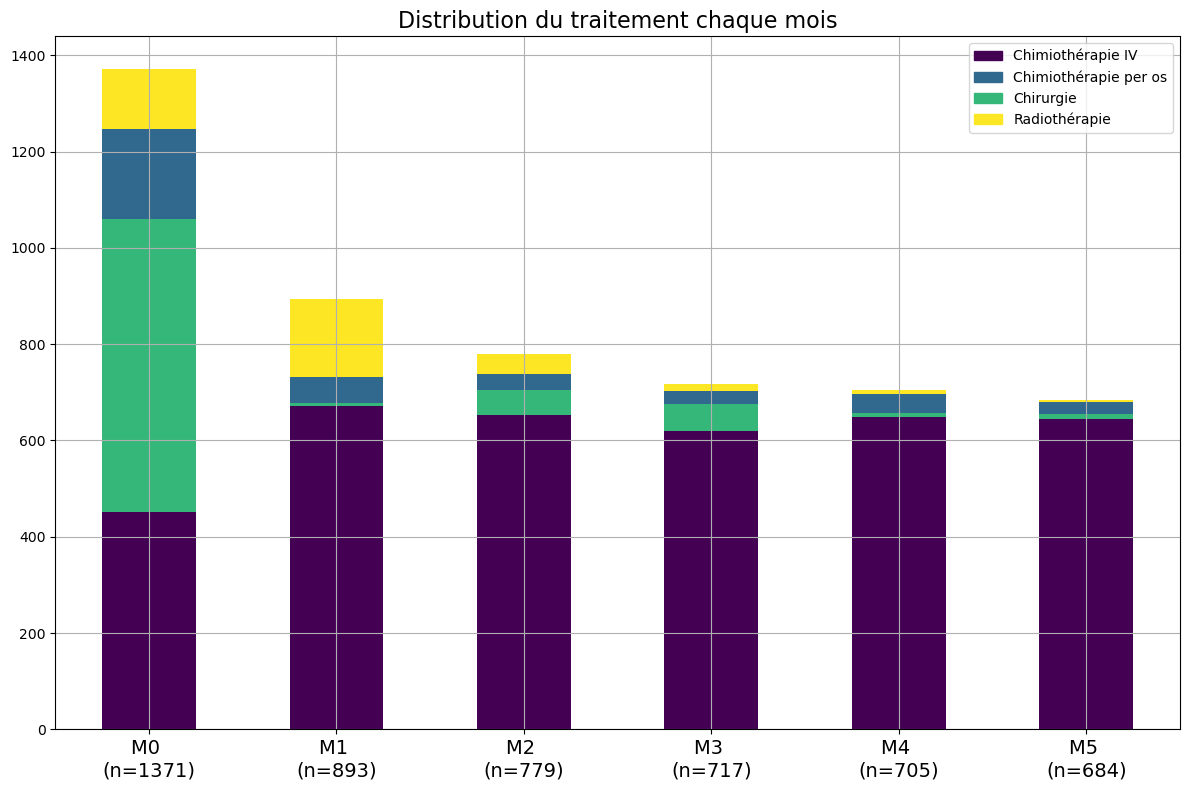

In [ ]:
# Use the same viridis_colors_list for consistency
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[alphabet[i]], label=alphabet[i]) for i in range(len(alphabet))]

# Plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
care_status_counts.T.plot.bar(stacked=True, color=[color_mapping[state] for state in care_status_counts.index], ax=ax)

plt.title('Distribution du traitement chaque mois', fontsize=16)

# Set x-ticks and labels
xticks = list(range(0, len(care_status_counts.columns)))
xlabels = [f'M{i} \n(n={sum(care_status_counts.iloc[:, i])})' for i in range(len(care_status_counts.columns))]
plt.xticks(ticks=xticks, labels=xlabels, rotation=0, fontsize=14)

plt.legend(handles=legend_handles, labels=states, loc='upper right', ncol=1, title=None)
plt.grid(True)
plt.tight_layout()
plt.show()

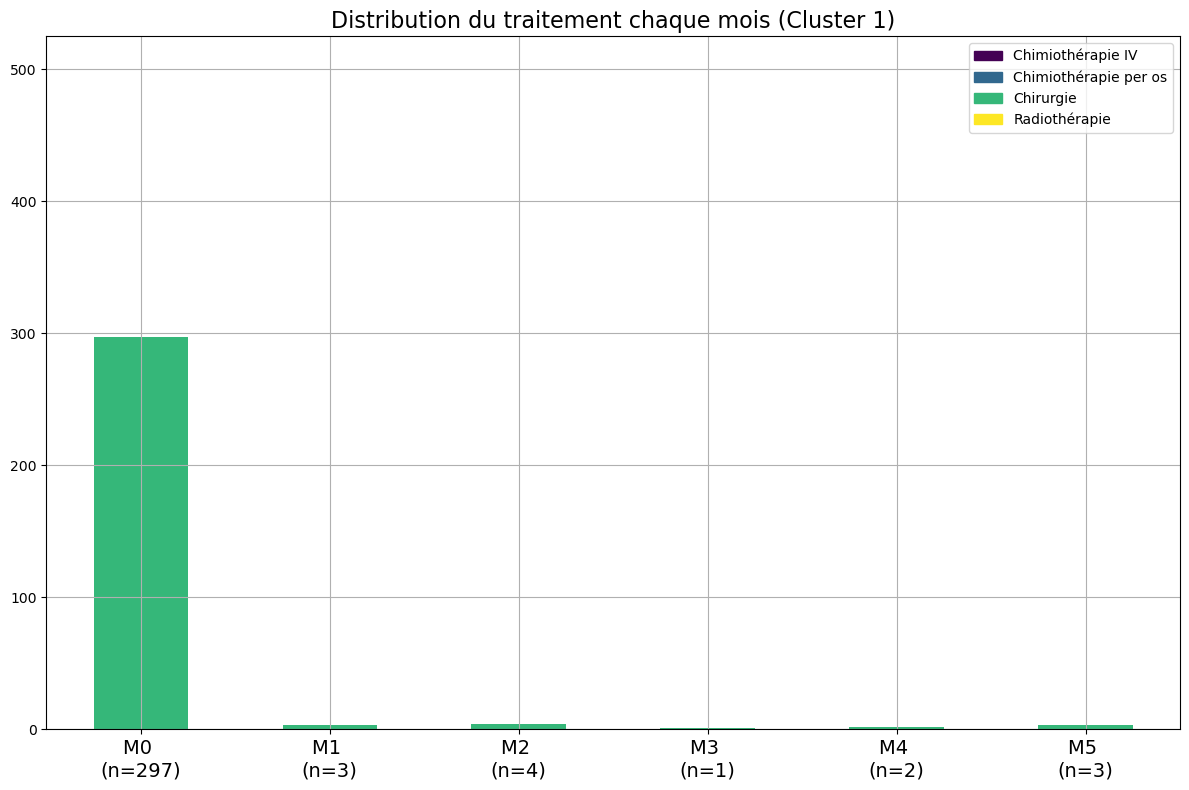

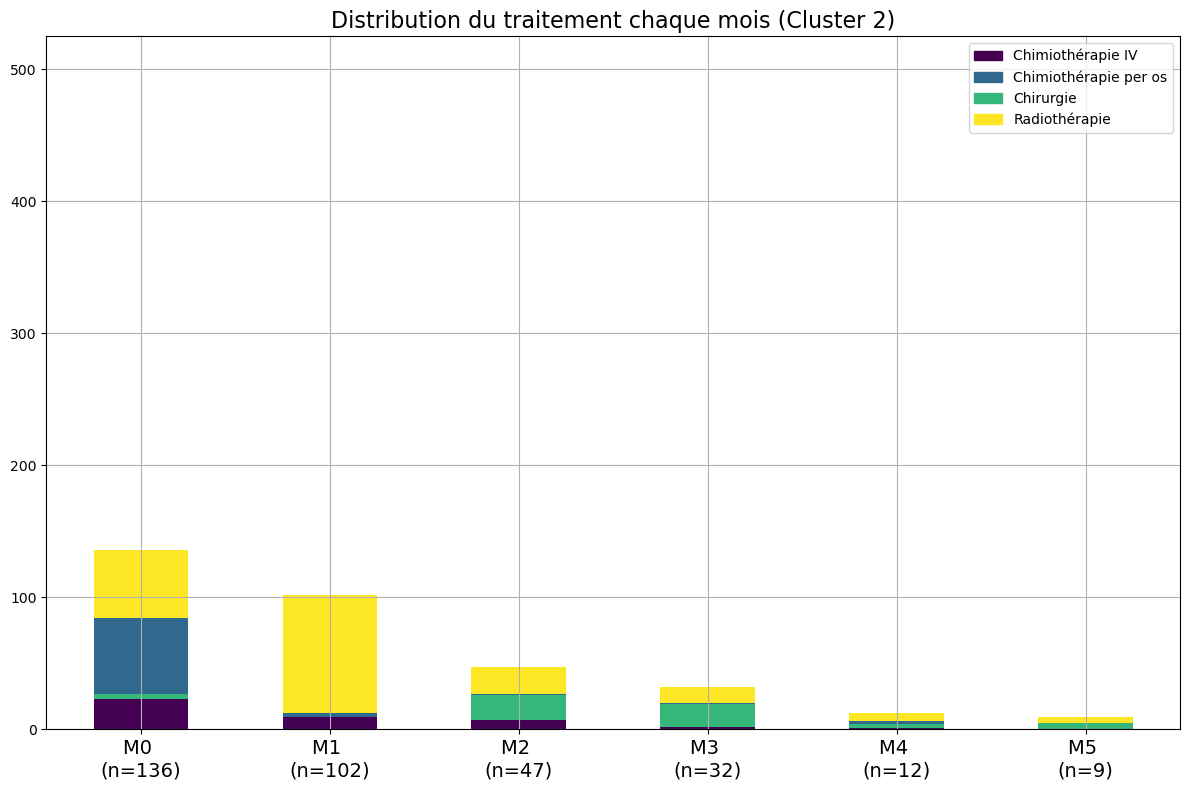

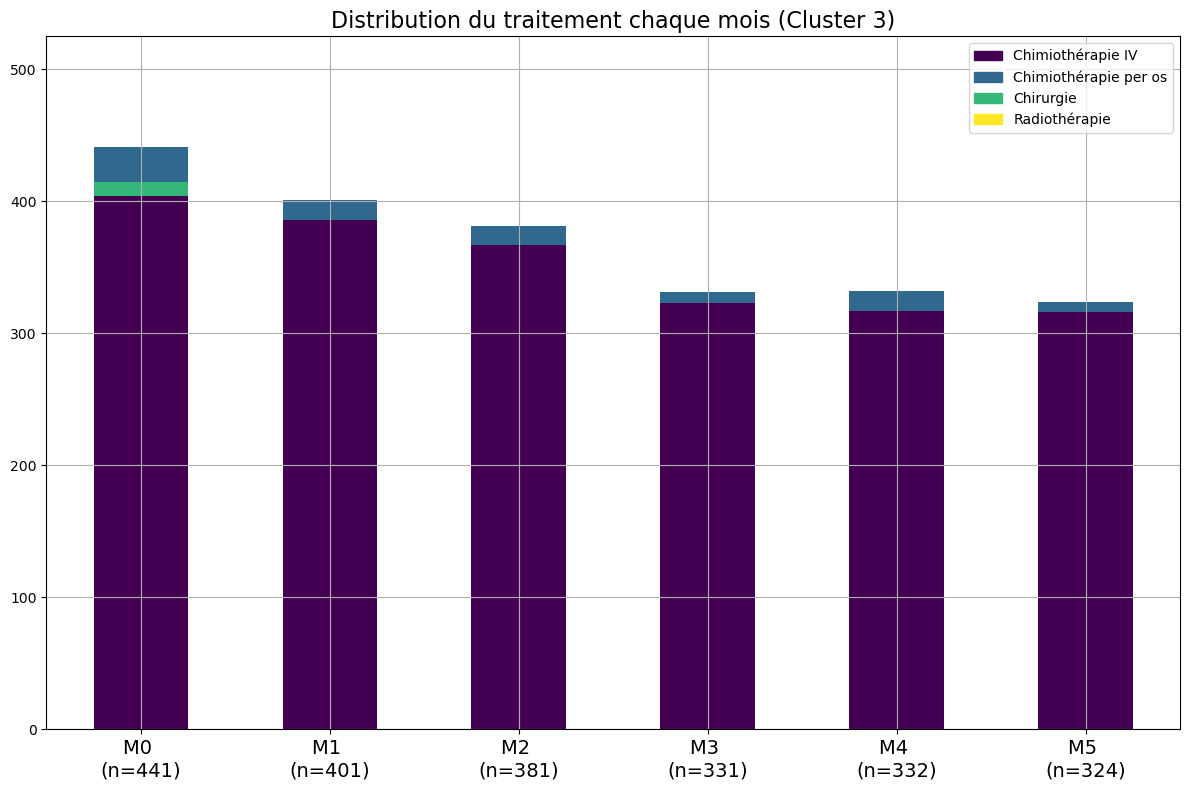

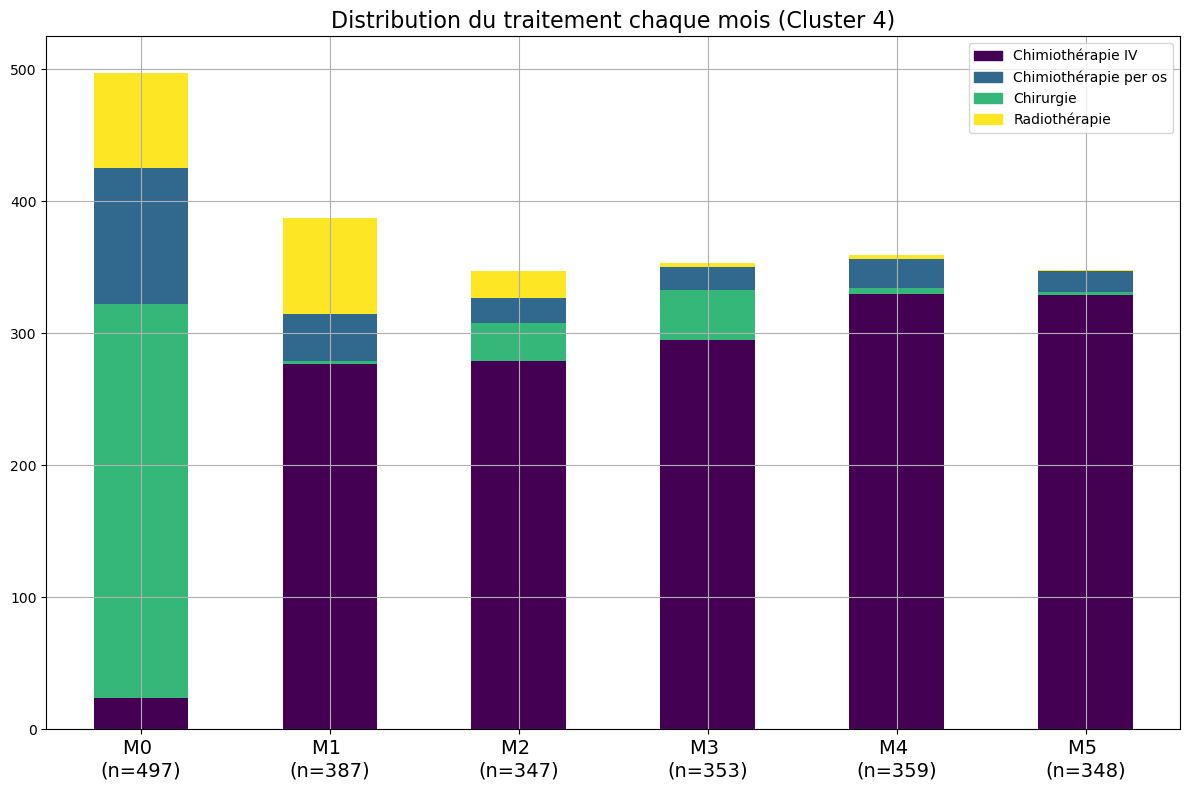

In [151]:
# Calculate the maximum y-axis value across all clusters
max_y_value = max(df.drop(columns=['Cluster']).apply(pd.Series.value_counts).fillna(0).sum().max() for cluster_id in sorted(df['Cluster'].unique()))

# Iterate over each unique cluster
df['Cluster'] = clusters
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    # Calculate care status counts for the current cluster
    care_status_counts_cluster = cluster_data.drop(columns=['Cluster']).apply(pd.Series.value_counts).fillna(0)
    status_counts_cluster = care_status_counts_cluster.T

    # Plot the distribution for the current cluster
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    care_status_counts_cluster.T.plot.bar(
        stacked=True,
        color=[color_mapping[state] for state in care_status_counts_cluster.index],
        ax=ax
    )

    plt.title(f'Distribution du traitement chaque mois (Cluster {cluster_id})', fontsize=16)
    xticks = list(range(0, len(care_status_counts_cluster.columns)))
    xlabels = [f'M{i} \n(n={int(sum(care_status_counts_cluster.iloc[:, i]))})' for i in range(len(care_status_counts_cluster.columns))]
    plt.xticks(ticks=xticks, labels=xlabels, rotation=0, fontsize=14)
    plt.ylim(0, 525)  # Set the same y-axis range for all plots
    plt.legend(handles=legend_handles, labels=states, loc='upper right', ncol=1, title=None)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [46]:
for treatment, treatment_label, color in zip(alphabet, states, viridis_colors_list):
    treatment_data = df[df.eq(treatment).any(axis=1)]
    months = treatment_data.columns
    percentages = (treatment_data.apply(lambda x: x.value_counts().get(treatment, 0)) / len(treatment_data)) * 100
    percentages = percentages.fillna(0)
    plt.bar(months, percentages, bottom=cumulative_values, label=f'{treatment_label}', color=color,)
    plt.xticks(months[::2], rotation=90)
    cumulative_values += percentages


plt.title('Number of Patients under Each State Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Patients')
plt.legend(title=None)
plt.tight_layout()
plt.show()

ValueError: Unable to coerce to Series, length must be 7: given 4

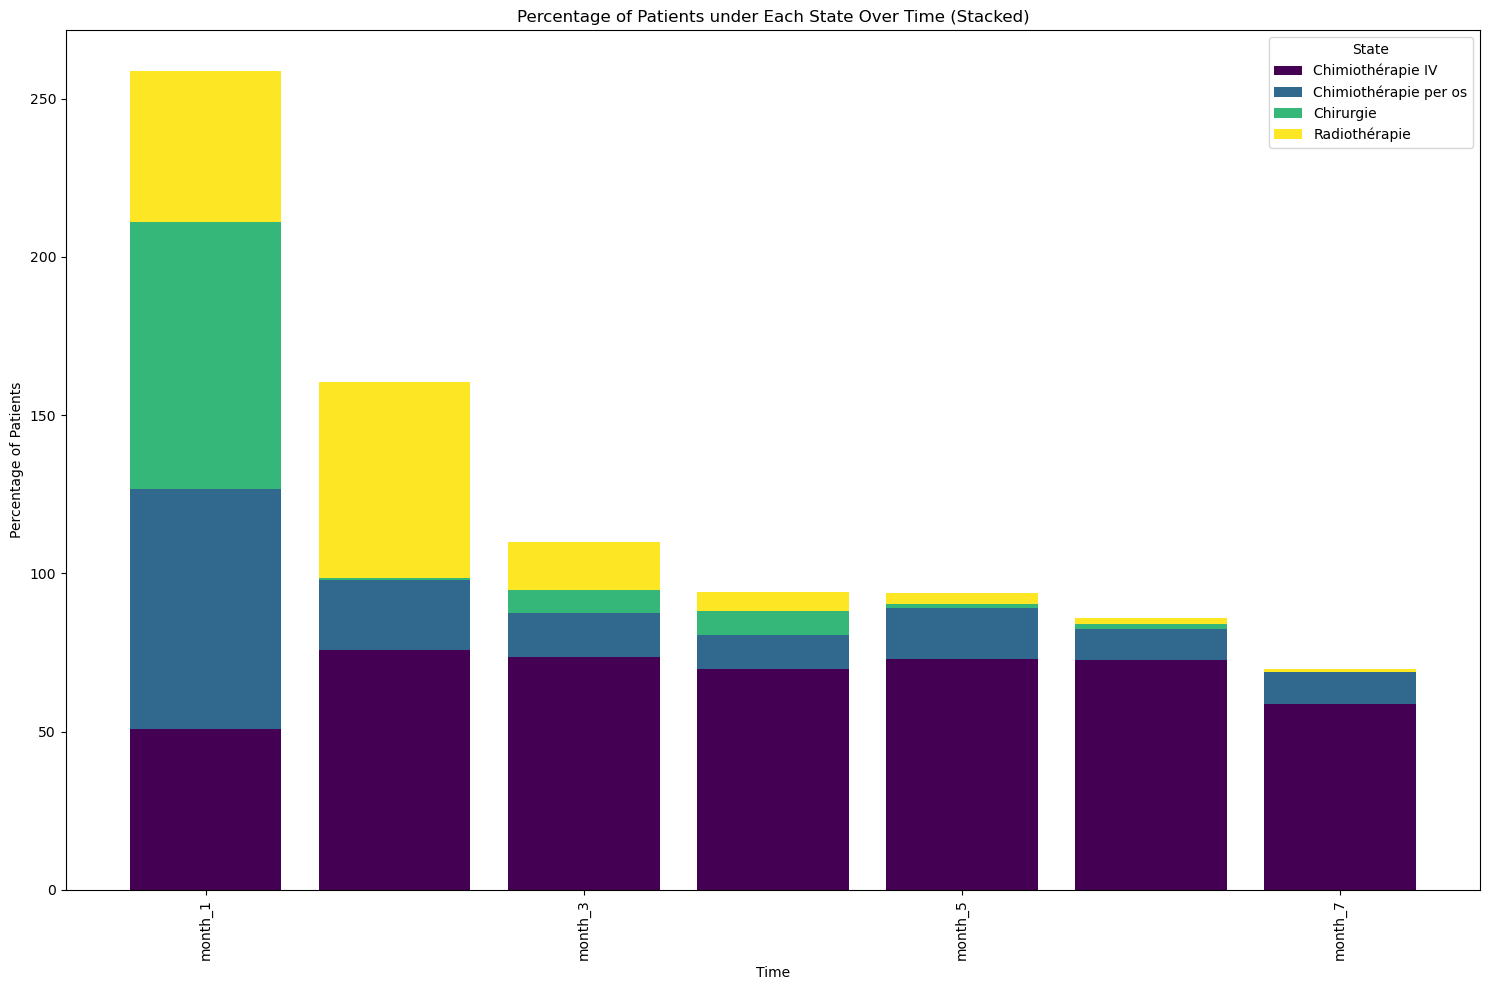

In [43]:
tca.bar_treatment_percentage()

In [16]:
pivoted_data['Cluster'] = clusters

In [25]:
df = df.merge(pivoted_data[['id', 'Cluster']], left_on='ID_PATIENT', right_on='id', how='left')

In [26]:
df

,ID_PATIENT,DATE,Months_Since_First_Events,Lib_traitement,id,Cluster
0,1101100224,2010-04-01,0,Chirurgie,1101100224,4
1,1101100224,2010-05-10,1,Chimiothérapie IV,1101100224,4
2,1101100224,2010-06-17,2,Chimiothérapie IV,1101100224,4
3,1101100224,2010-07-01,3,Chimiothérapie IV,1101100224,4
4,1101100224,2010-08-19,4,Chimiothérapie IV,1101100224,4
...,...,...,...,...,...,...
5692,2395100171,2010-07-09,3,Chimiothérapie IV,2395100171,3
5693,2395100171,2010-08-06,4,Chimiothérapie IV,2395100171,3
5694,2395100318,2010-09-16,0,Chimiothérapie IV,2395100318,3
5695,2395100318,2010-10-20,1,Chimiothérapie IV,2395100318,3


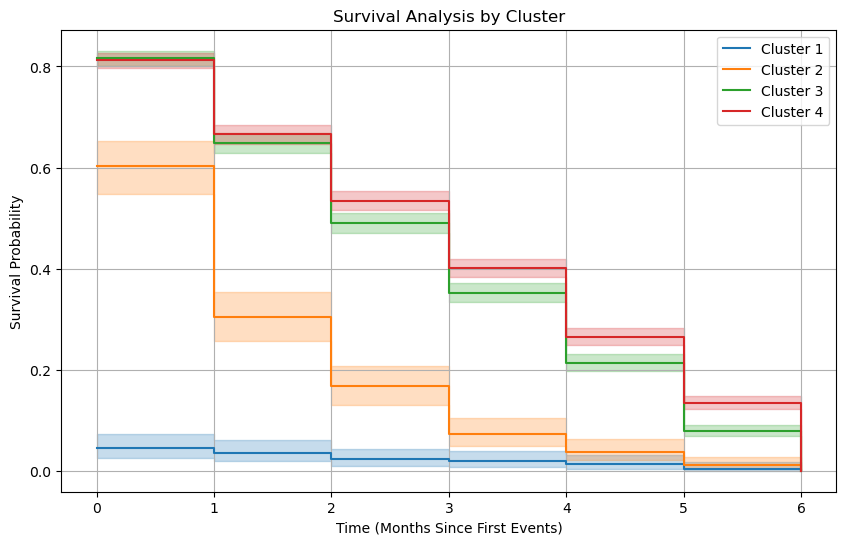

In [27]:
from lifelines import KaplanMeierFitter

import matplotlib.pyplot as plt

# Add cluster information to the original dataframe
# df['Cluster'] = clusters

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot survival curves for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    # Assuming 'Months_Since_First_Events' is the time column and all events are observed
    kmf.fit(durations=cluster_data['Months_Since_First_Events'], event_observed=[1] * len(cluster_data))
    kmf.plot_survival_function(label=f'Cluster {cluster_id}')

plt.title('Survival Analysis by Cluster')
plt.xlabel('Time (Months Since First Events)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid()
plt.show()

The previous plot is a Kaplan-Meier survival curve, which is used to estimate the survival probability over time for different groups (in this case, clusters). Here's how to interpret it:

1. **X-axis (Time)**: Represents the time in months since the first event (`Months_Since_First_Events`).

2. **Y-axis (Survival Probability)**: Represents the probability of survival (or remaining in the study without experiencing the event of interest) at a given time.

3. **Lines (Clusters)**: Each line corresponds to a specific cluster (e.g., `Cluster 1`, `Cluster 2`, etc.). The survival curve shows how the survival probability changes over time for patients in that cluster.

4. **Legend**: Indicates which line corresponds to which cluster.

5. **Interpretation**:
    - A steeper drop in the curve indicates a higher rate of events (e.g., treatment failure or death) in that cluster.
    - A flatter curve indicates better survival or fewer events over time.
    - Differences between clusters suggest that the clusters have distinct survival patterns, which may reflect differences in treatment effectiveness, patient characteristics, or other factors.

6. **Censoring**: If there are censored data points (patients lost to follow-up or study end), they are typically marked with small vertical ticks on the lines.

This plot helps compare survival outcomes across clusters and identify which groups may require further investigation or intervention.

id = "Identifiant Patient", \
month = "Mois depuis la diagnostic", \
care_status = "Statut dans les soins", \
wealth = "Niveau de richesse", \
distance_clinic = "Distance à la clinique la plus proche" 

In [3]:
events= list(df["care_status"].unique())
events

['D', 'T', 'C', 'S']

"diagnostiqué, mais pas suivi" = "D", \
"suivi, mais pas sous traitement" = "C", \
"sous traitement, mais infection non contrôlée" = "T", \
"sous traitement et infection contrôlée" = "S"

In [4]:
selected_cols = df[['id', 'month', 'care_status']]
pivoted_data = selected_cols.pivot(index='id', columns='month', values='care_status')

# Renommer les colonnes avec un préfixe "month_"
pivoted_data.columns = ['month_' + str(int(col)+1) for col in pivoted_data.columns]

pivoted_data

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_42,month_43,month_44,month_45,month_46,month_47,month_48,month_49,month_50,month_51
id,,,,,,,,,,,,,,,,,,,,,
3,D,D,D,D,D,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,D,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,D,D,D,D,D,D,D,D,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,D,D,D,D,T,T,T,C,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,D,D,S,S,S,S,S,S,S,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,D,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9988,D,C,C,T,T,T,T,T,T,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9989,D,C,T,T,S,S,S,S,S,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
colors = ['red', 'blue', 'green', 'yellow']

fig = go.Figure()
for treatment, color in zip(events, colors):
    treatment_data = pivoted_data[pivoted_data.eq(treatment).any(axis=1)]
    months = treatment_data.columns
    
    # Calculate the percentage of patients under the current treatment for each month
    percentages = (treatment_data.apply(lambda x: x.value_counts().get(treatment, 0)) / len(treatment_data)) * 100

    fig.add_trace(go.Scatter(x=months, y=percentages, mode='lines', name=treatment, line=dict(color=color)))

fig.update_layout(
    title='Percentage of Patients under Each Treatment Over Time',
    xaxis_title='Time',
    yaxis_title='Percentage of Patients',
    legend_title='Treatment',
    yaxis=dict(tickformat=".2f")
)

fig.show()

In [6]:
drug_mapping = {"D":2, "C":4, "T":6, "S":8}
df_subsets_numeriques = pivoted_data.replace(drug_mapping)
df_subsets_numeriques

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_42,month_43,month_44,month_45,month_46,month_47,month_48,month_49,month_50,month_51
id,,,,,,,,,,,,,,,,,,,,,
3,2,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2,2.0,2.0,2.0,6.0,6.0,6.0,4.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2,2.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9988,2,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9989,2,4.0,6.0,6.0,8.0,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Test des méthodes de clustering sur un échantillon de patients 

In [16]:
df_random_sample = df_subsets_numeriques.sample(n=300)
df_random_sample.shape

(300, 51)

In [49]:
df_random_sample1 = pivoted_data.sample(n=300) 
df_random_sample1.shape

(300, 51)

In [22]:
df_random_sample1.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_42,month_43,month_44,month_45,month_46,month_47,month_48,month_49,month_50,month_51
id,,,,,,,,,,,,,,,,,,,,,
7760,D,D,D,D,D,D,C,T,T,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,D,D,D,D,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8034,D,D,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1567,D,D,D,D,D,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1925,D,D,D,D,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_random_sample1['Sequence'] = df_random_sample1.apply(lambda x: '-'.join(x.astype(str)), axis=1)
df_merged = df_random_sample1.reset_index().rename(columns = { 'index': 'id' })
df_merged = df_merged[['id', 'Sequence']]
df_merged.head()

,id,Sequence
0,8386,D-C-C-C-C-D-C-T-T-T-S-S-S-S-S-S-S-nan-nan-nan-...
1,5000,D-D-D-D-D-D-D-D-D-D-D-D-S-S-S-S-S-S-S-S-S-nan-...
2,9927,D-D-D-D-D-D-D-D-C-T-T-T-C-D-D-C-C-C-C-C-D-D-D-...
3,5096,D-D-nan-nan-nan-nan-nan-nan-nan-nan-nan-nan-na...
4,1840,D-D-D-D-D-D-D-D-D-D-D-D-D-D-D-D-D-D-D-nan-nan-...


In [61]:
unique_states = sorted(set('-'.join(df_merged['Sequence']).replace('-', '')))
num_states = len(unique_states)
substitution_matrix = np.zeros((num_states, num_states))
print(substitution_matrix.shape)

(6, 6)


In [62]:
for i in range(num_states):
    for j in range(num_states):
        if i != j:
            substitution_matrix[i, j] = 1

substitution_df = pd.DataFrame(substitution_matrix, index=unique_states, columns=unique_states)
print(substitution_df)

     C    D    S    T    a    n
C  0.0  1.0  1.0  1.0  1.0  1.0
D  1.0  0.0  1.0  1.0  1.0  1.0
S  1.0  1.0  0.0  1.0  1.0  1.0
T  1.0  1.0  1.0  0.0  1.0  1.0
a  1.0  1.0  1.0  1.0  0.0  1.0
n  1.0  1.0  1.0  1.0  1.0  0.0


In [29]:
# Fonction pour calculer la matrice de substitution
def calculate_substitution_matrix(sequences):
    # Extraire les états uniques
    unique_states = sorted(set('-'.join(sequences)))
    num_states = len(unique_states)

    # Initialiser la matrice de substitution
    substitution_matrix = np.zeros((num_states, num_states))

    # Calculer les coûts de substitution (exemple simple : coût de 1 pour toutes les substitutions)
    for i in range(num_states):
        for j in range(num_states):
            if i != j:
                substitution_matrix[i, j] = 1

    # Créer un DataFrame pour la matrice de substitution
    substitution_df = pd.DataFrame(substitution_matrix, index=unique_states, columns=unique_states)

    return substitution_df

# Calculer la matrice de substitution
substitution_matrix = calculate_substitution_matrix(df1['Sequence'])

# Afficher la matrice de substitution
print(substitution_matrix)

     -    A    B    C    D
-  0.0  1.0  1.0  1.0  1.0
A  1.0  0.0  1.0  1.0  1.0
B  1.0  1.0  0.0  1.0  1.0
C  1.0  1.0  1.0  0.0  1.0
D  1.0  1.0  1.0  1.0  0.0


### 1. Avec la distance de Hamming

In [12]:
data_array_rs_ham = df_random_sample.to_numpy()

distance_matrix_rs_ham = pdist(
    data_array_rs_ham,
    metric='hamming' # Hamming distance is used for comparison of sequential data
                     # it is defined as the number of positions at which the corresponding symbols are different (0 if the symbols are the same and 1 if they are different)
    ) 
                                                                                                            
len(distance_matrix_rs_ham)

44850

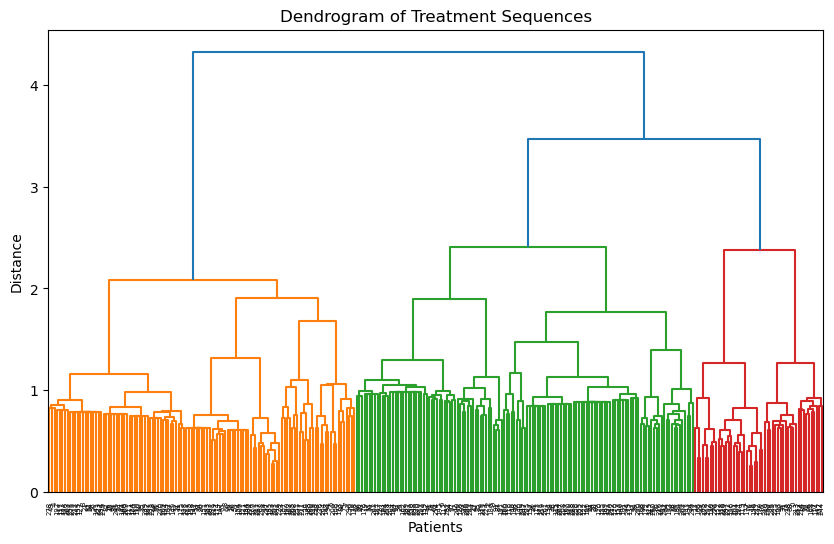

In [45]:
linkage_matrix_rs_ham = linkage(distance_matrix_rs_ham,
                                method='ward', # Ward's method minimizes the variance of the clusters being merged
                                optimal_ordering=True # reorders the data points to minimize the distance between the points in the dendrogram
                                )

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_rs_ham)
plt.title('Dendrogram of Treatment Sequences')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

In [46]:
# A measure of how faithfully the dendrogram preserves the pairwise distances between the original data points.
# In other words, it compares the actual pairwise distances of the data points with the distances implied by the hierarchical clustering.
# A higher cophenetic correlation coefficient indicates that the clustering is a good representation of the data's structure.
c, coph_dists = cophenet(linkage_matrix_rs_ham, distance_matrix_rs_ham)
c

0.43712259588028074

In [16]:
leaves_order_rs_ham = list(hierarchy.leaves_list(linkage_matrix_rs_ham))
data_array_rs_ham_order = data_array_rs_ham[leaves_order_rs_ham]

colors = ['blue', 'orange', 'green', 'red']
heatmap_ham = go.Heatmap(z=data_array_rs_ham_order, colorscale= 'viridis')

# Créer une figure
fig = go.Figure(data=heatmap_ham)
fig.update_layout(
    title='TCA with Hamming Distance',
    xaxis_title='Temps',
    yaxis_title='Patients',
)

# Afficher le graphique
fig.show()

### 2. Avec la méthode Optimal Matching (algo Needleman-Wunsch)

In [1]:
import numpy as np
import pandas as pd

def seqcost(seqdata, method, cval=None, with_missing=False, miss_cost=None,
            time_varying=False, weighted=True, transition="both", lag=1,
            miss_cost_fixed=None, state_features=None, feature_weights=None,
            feature_type=None, proximities=False):

    # if not isinstance(seqdata, pd.DataFrame):
    #     raise ValueError("data is NOT a sequence object, see seqdef function to create one")

    # metlist = ["CONSTANT", "TRATE", "FEATURES", "FUTURE", "INDELS", "INDELSLOG"]
    # if method not in metlist:
    #     raise ValueError(f"method must be one of: {' '.join(metlist)}")

    # transitionlist = ["previous", "next", "both"]
    # if transition not in transitionlist:
    #     raise ValueError(f"transition must be one of: {' '.join(transitionlist)}")

    # if with_missing and not seqdata.isna().any().any():
    #     with_missing = False
    #     print("seqcost: 'with_missing' set as FALSE as 'seqdata' has no non-void missing values")

    ret = {}
    ret['indel'] = 1
    alphabet = sorted(set(''.join(seqdata['Sequence'].tolist())))

    cval4cond = time_varying and method == "TRATE" and transition == "both"
    if cval is None:
        cval = 4 if cval4cond else 2
    if miss_cost is None:
        miss_cost = cval
    if miss_cost_fixed is None:
        miss_cost_fixed = method in ["INDELS", "INDELSLOG"]

    if with_missing:
        alphabet.append('*')  # Assuming '*' represents missing values

    alphsize = len(alphabet)

    if method == "CONSTANT":
        if cval is None:
            raise ValueError("no value for the constant substitution-cost")
        if time_varying:
            time = seqdata.shape[1]
            print(f"creating {alphsize}x{alphsize}x{time} time varying substitution-cost matrix using {cval} as constant value")
            costs = np.full((alphsize, alphsize, time), cval)
            for i in range(time):
                np.fill_diagonal(costs[:, :, i], 0)
        else:
            print(f"creating {alphsize}x{alphsize} substitution-cost matrix using {cval} as constant value")
            costs = np.full((alphsize, alphsize), cval)
            np.fill_diagonal(costs, 0)

    elif method == "FUTURE":
        if time_varying:
            raise ValueError("time.varying substitution cost is not (yet) implemented for method FUTURE.")
        print("creating substitution-cost matrix using common future...")
        tr = seqtrate(seqdata, time_varying=False, weighted=weighted, lag=lag, with_missing=with_missing)
        costs = chisqdista(tr)
        np.fill_diagonal(costs, 0)
        ret['indel'] = 0.5 * np.max(costs)

    elif method == "FEATURES":
        if time_varying:
            raise ValueError("time.varying substitution cost is not (yet) implemented for method FEATURES.")
        if state_features is None or state_features.shape[0] != len(alphabet):
            raise ValueError("state.features should be a data.frame containing one row per state (possibly one for missing values).")
        if feature_weights is None:
            feature_weights = np.ones(state_features.shape[1])
        costs = daisy(state_features, metric="gower", weights=feature_weights, type=feature_type)
        np.fill_diagonal(costs, 0)
        ret['indel'] = 0.5 * np.max(costs)

    elif method in ["INDELS", "INDELSLOG"]:
        if time_varying:
            indels = seqstatd(seqdata, with_missing=with_missing)['Frequencies']
        else:
            ww = seqdata.get('weights', np.ones(seqdata.shape[0]))
            indels = np.array(pd.crosstab(np.repeat(ww, seqdata.shape[1]), np.hstack(seqdata.values)).loc[alphabet])

        indels[np.isnan(indels)] = 1
        if method == "INDELSLOG":
            indels = np.log(2 / (1 + indels))
        else:
            indels = 1 / indels
            indels[np.isinf(indels)] = np.finfo(np.float64).max

        ret['indel'] = indels

        if time_varying:
            time = seqdata.shape[1]
            print(f"creating {alphsize}x{alphsize}x{time} time varying substitution-cost matrix using {method}")
            costs = np.zeros((alphsize, alphsize, time))
            for t in range(time):
                for i in range(alphsize):
                    for j in range(alphsize):
                        if i != j:
                            costs[i, j, t] = indels[i, t] + indels[j, t]
        else:
            costs = np.zeros((alphsize, alphsize))
            for i in range(alphsize):
                for j in range(alphsize):
                    if i != j:
                        costs[i, j] = indels[i] + indels[j]

        costs[np.isinf(costs)] = np.finfo(np.float64).max

    elif method == "TRATE":
        if time_varying:
            print("creating time varying substitution-cost matrix using transition rates ...")
            tr = seqtrate(seqdata, time_varying=True, weighted=weighted, lag=lag, with_missing=with_missing)
            tmat = tr.shape[0]
            time = seqdata.shape[1]
            costs = np.zeros((alphsize, alphsize, time))

            def tratecostBoth(trate, time, state1, state2, debut, fin):
                cost = 0
                if not debut:
                    cost -= trate[state1, state2, time - 1] + trate[state2, state1, time - 1]
                if not fin:
                    cost -= trate[state1, state2, time] + trate[state2, state1, time]
                if not debut and not fin:
                    return cost + cval
                else:
                    return cval + 2 * cost

            def tratecostPrevious(trate, time, state1, state2, debut, fin):
                cost = 0
                if not debut:
                    cost -= trate[state1, state2, time - 1] + trate[state2, state1, time - 1]
                return cval + cost

            def tratecostNext(trate, time, state1, state2, debut, fin):
                cost = 0
                if not fin:
                    cost -= trate[state1, state2, time] + trate[state2, state1, time]
                return cval + cost

            if transition == "previous":
                tratecost = tratecostPrevious
            elif transition == "next":
                tratecost = tratecostNext
            else:
                tratecost = tratecostBoth

            for t in range(time):
                for i in range(tmat - 1):
                    for j in range(i + 1, tmat):
                        cost = max(0, tratecost(tr, t, i, j, t == 1, t == time))
                        costs[i, j, t] = cost
                        costs[j, i, t] = cost
        else:
            print("creating substitution-cost matrix using transition rates ...")
            tr = seqtrate(seqdata, time_varying=False, weighted=weighted, lag=lag, with_missing=with_missing)
            tmat = tr.shape[0]
            costs = np.zeros((alphsize, alphsize))
            np.fill_diagonal(costs, 0)
            for i in range(tmat - 1):
                for j in range(i + 1, tmat):
                    cost = cval - tr[i, j] - tr[j, i]
                    costs[i, j] = cost
                    costs[j, i] = cost
            ret['indel'] = 0.5 * np.max(costs)

    if with_missing and miss_cost_fixed:
        if time_varying:
            costs[alphsize, :(alphsize - 1), :] = miss_cost
            costs[:(alphsize - 1), alphsize, :] = miss_cost
        else:
            costs[alphsize, :(alphsize - 1)] = miss_cost
            costs[:(alphsize - 1), alphsize] = miss_cost

    if time_varying:
        dimnames = [alphabet, alphabet, seqdata.columns]
    else:
        dimnames = [alphabet, alphabet]

    if proximities:
        ret['prox'] = 1 - costs / np.max(costs)
    else:
        ret['sm'] = costs

    return ret

# Helper functions (simplified versions)
def seqtrate(seqdata, time_varying, weighted, lag, with_missing):
    # Placeholder for seqtrate function
    return np.random.rand(len(seqdata), len(seqdata), seqdata.shape[1] if time_varying else 1)

def chisqdista(mat):
    cs = np.sum(mat, axis=0)
    cs[cs == 0] = np.inf
    Pdot = 1 / cs
    n = mat.shape[0]
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = np.sum(Pdot * (mat[i, :] - mat[j, :])**2)
            dist[j, i] = dist[i, j]
    return np.sqrt(dist)

def daisy(state_features, metric, weights, type):
    # Placeholder for daisy function
    return np.random.rand(state_features.shape[0], state_features.shape[0])

def seqstatd(seqdata, with_missing):
    # Placeholder for seqstatd function
    return {'Frequencies': np.random.rand(seqdata.shape[0], seqdata.shape[1])}

# Example usage
data = {
    'ID': [1, 2, 3, 4, 5],
    'Sequence': [
        'A-B-C',
        'A-B-D',
        'A-C-D',
        'B-C-D',
        'A-B-C-D'
    ]
}

df = pd.DataFrame(data)
result = seqcost(df, method="CONSTANT", cval=2)
print(result)


creating 5x5 substitution-cost matrix using 2 as constant value
{'indel': 1, 'sm': array([[0, 2, 2, 2, 2],
       [2, 0, 2, 2, 2],
       [2, 2, 0, 2, 2],
       [2, 2, 2, 0, 2],
       [2, 2, 2, 2, 0]])}


In [2]:
ret = {}
ret['indel'] = 1
alphabet = sorted(set(''.join(df['Sequence'].tolist())))
print(alphabet)

['-', 'A', 'B', 'C', 'D']


In [ ]:
# Fonction pour calculer la matrice de substitution
def calculate_substitution_matrix(sequences):
    # Extraire les états uniques
    unique_states = sorted(set(''.join(sequences)))
    num_states = len(unique_states)

    # Initialiser la matrice de substitution
    substitution_matrix = np.zeros((num_states, num_states))

    # Calculer les coûts de substitution (exemple simple : coût de 1 pour toutes les substitutions)
    for i in range(num_states):
        for j in range(num_states):
            if i != j:
                substitution_matrix[i, j] = 1

    # Créer un DataFrame pour la matrice de substitution
    substitution_df = pd.DataFrame(substitution_matrix, index=unique_states, columns=unique_states)

    return substitution_df

# Calculer la matrice de substitution
substitution_matrix = calculate_substitution_matrix(df1['Sequence'])

# Afficher la matrice de substitution
print(substitution_matrix)

In [7]:
def needleman_wunsch(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
    m, n = len(seq1), len(seq2)
    score_matrix = np.zeros((m+1, n+1))

    # Initialisation de la matrice de scores
    score_matrix[:, 0] = gap_penalty * np.arange(m+1)
    score_matrix[0, :] = gap_penalty * np.arange(n+1)

    # Remplissage de la matrice de scores
    match_mismatch = np.vectorize(lambda x, y: match_score if x == y else mismatch_score)
    for i in range(1, m+1):
        for j in range(1, n+1):
            match = score_matrix[i-1, j-1] + match_mismatch(seq1[i-1], seq2[j-1])
            delete = score_matrix[i-1, j] + gap_penalty
            insert = score_matrix[i, j-1] + gap_penalty
            score_matrix[i, j] = max(match, delete, insert)

    # Score d'alignement optimal
    optimal_score = score_matrix[m, n]

    return optimal_score

In [8]:
def sequence_distance(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
    optimal_score = needleman_wunsch(seq1, seq2, match_score, mismatch_score, gap_penalty)
    max_length = max(len(seq1), len(seq2))
    normalized_score = optimal_score / max_length
    distance = 1 - normalized_score
    return distance

In [12]:
# distances = []
# for i in range(len(df_subsets_numeriques)):
#     for j in range(i + 1, len(df_subsets_numeriques)):
#         seq1 = df_subsets_numeriques.iloc[i].dropna().values
#         seq2 = df_subsets_numeriques.iloc[j].dropna().values
#         # optimal_score, scores_matrix = needleman_wunsch(first_array_nw, second_array_nw)
#         distances.append(sequence_distance(seq1, seq2))

# distance_matrix_rs_nw = np.array(distances)
distance_matrix_rs_nw = np.zeros((len(df_subsets_numeriques), len(df_subsets_numeriques)))

for i in range(len(df_subsets_numeriques)):
    for j in range(i + 1, len(df_subsets_numeriques)):
        seq1 = df_subsets_numeriques.iloc[i].dropna().values
        seq2 = df_subsets_numeriques.iloc[j].dropna().values
        distance_matrix_rs_nw[i, j] = sequence_distance(seq1, seq2)
        distance_matrix_rs_nw[j, i] = distance_matrix_rs_nw[i, j]  # Symmetric matrix

distance_matrix_rs_nw

array([[0.        , 2.        , 0.75      , ..., 2.33333333, 2.6       ,
        2.36842105],
       [2.        , 0.        , 2.25      , ..., 2.66666667, 2.8       ,
        2.68421053],
       [0.75      , 2.25      , 0.        , ..., 2.16666667, 2.5       ,
        2.26315789],
       ...,
       [2.33333333, 2.66666667, 2.16666667, ..., 0.        , 1.2       ,
        1.10526316],
       [2.6       , 2.8       , 2.5       , ..., 1.2       , 0.        ,
        0.95      ],
       [2.36842105, 2.68421053, 2.26315789, ..., 1.10526316, 0.95      ,
        0.        ]])

In [10]:
distances = []
for i in range(len(df_subsets_numeriques)):
    for j in range(i + 1, len(df_subsets_numeriques)):
        seq1 = df_subsets_numeriques.iloc[i].dropna().values
        seq2 = df_subsets_numeriques.iloc[j].dropna().values
        # optimal_score, scores_matrix = needleman_wunsch(first_array_nw, second_array_nw)
        distances.append(sequence_distance(seq1, seq2))

distance_matrix_rs_nw = np.array(distances)

KeyboardInterrupt: 

In [17]:
# def needleman_wunsch(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
#     m, n = len(seq1), len(seq2)
#     score_matrix = np.zeros((m+1, n+1))

#     # Initialisation de la matrice de scores
#     for i in range(m+1):
#         score_matrix[i, 0] = gap_penalty * i
#     for j in range(n+1):
#         score_matrix[0, j] = gap_penalty * j

#     # Remplissage de la matrice de scores
#     for i in range(1, m+1):
#         for j in range(1, n+1):
#             match = score_matrix[i-1, j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_score)
#             delete = score_matrix[i-1, j] + gap_penalty
#             insert = score_matrix[i, j-1] + gap_penalty
#             score_matrix[i, j] = max(match, delete, insert)

#     # Score d'alignement optimal
#     optimal_score = score_matrix[m, n]

#     return optimal_score#, score_matrix

# def sequence_distance(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
#     optimal_score = needleman_wunsch(seq1, seq2, match_score, mismatch_score, gap_penalty)
#     max_length = max(len(seq1), len(seq2))
#     normalized_score = optimal_score / max_length
#     distance = 1 - normalized_score
#     return distance


In [9]:
distances = []
for i in range(len(df_random_sample)):
    for j in range(i + 1, len(df_random_sample)):
        seq1 = df_random_sample.iloc[i].dropna().values
        seq2 = df_random_sample.iloc[j].dropna().values
        # optimal_score, scores_matrix = needleman_wunsch(first_array_nw, second_array_nw)
        distances.append(sequence_distance(seq1, seq2))

distance_matrix_rs_nw = np.array(distances)

NameError: name 'df_random_sample' is not defined

In [19]:
distance_matrix_rs_nw.shape

(44850,)

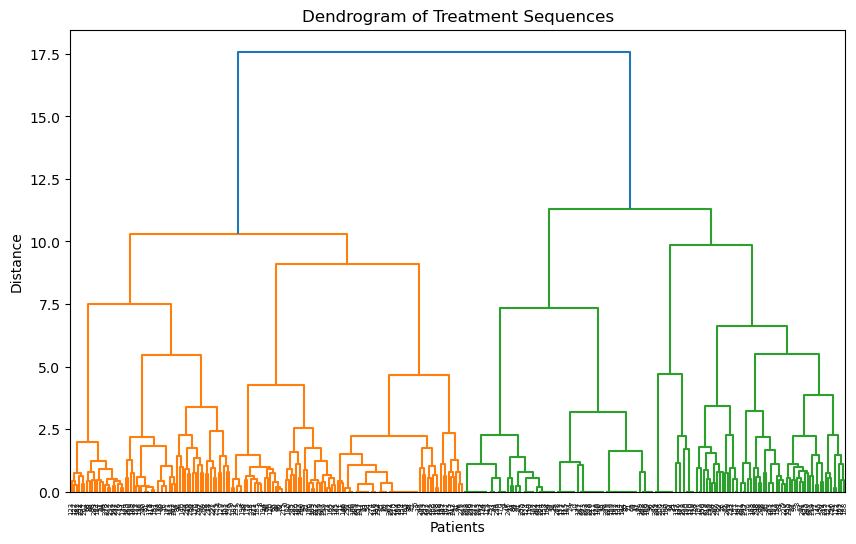

In [61]:
linkage_matrix_rs_nw = linkage(np.abs(distance_matrix_rs_nw), method='ward')#, optimal_ordering=True)

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_rs_nw)
plt.title('Dendrogram of Treatment Sequences')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

In [62]:
c, coph_dists = cophenet(linkage_matrix_rs_nw, np.abs(distance_matrix_rs_nw))
c

0.654399658308432

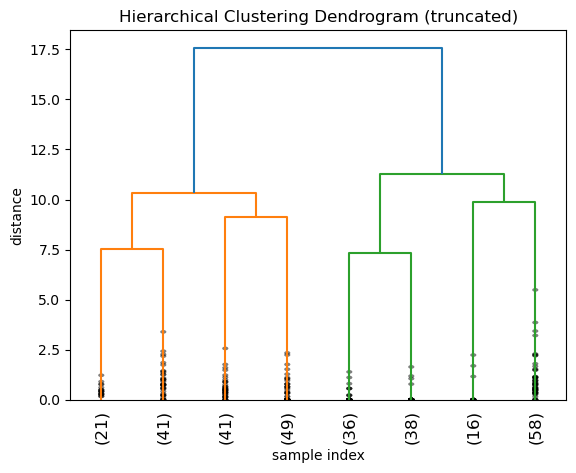

In [63]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    linkage_matrix_rs_nw,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()


In [64]:
from scipy.cluster.hierarchy import fcluster

max_d = 6
clusters = fcluster(linkage_matrix_rs_nw, max_d, criterion='distance')
len(clusters)

300

In [65]:
results1 = df_random_sample.copy()
results1['cluster'] = clusters
results1 = results1[['cluster'] + [col for col in results1.columns if col != 'cluster']]

In [66]:
results1

,cluster,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_42,month_43,month_44,month_45,month_46,month_47,month_48,month_49,month_50,month_51
id,,,,,,,,,,,,,,,,,,,,,
3125,3,2,2.0,2.0,2.0,2.0,2.0,6.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,5,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,3,2,2.0,2.0,2.0,6.0,6.0,6.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9915,9,2,4.0,4.0,4.0,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1347,2,2,2.0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,...,6.0,6.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,8,2,2.0,4.0,4.0,4.0,4.0,2.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5224,9,2,2.0,2.0,2.0,2.0,2.0,4.0,4.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818,5,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
data_array_rs_nw = df_random_sample.to_numpy()

leaves_order_rs_nw = list(hierarchy.leaves_list(linkage_matrix_rs_nw))
data_array_rs_nw_order = data_array_rs_nw[leaves_order_rs_nw]

colors = ['blue', 'orange', 'green', 'red']
heatmap_nw = go.Heatmap(z=data_array_rs_nw_order, colorscale= 'viridis')

# Créer une figure
fig = go.Figure(data=heatmap_nw)
fig.update_layout(
    title='TCA with Optimal Matching Distance',
    xaxis_title='Temps',
    yaxis_title='Patients',
)

# Afficher le graphique
fig.show()

In [106]:
n = len(df_subsets_numeriques)
m = len(df_subsets_numeriques.iloc[0])
distance_matrix = np.zeros((n, m))
distance_matrix.shape

(2929, 51)

In [113]:
for i in range(n):
    for j in range(i + 1, n):

        seq1 = df_subsets_numeriques.iloc[i].dropna().values
        seq2 = df_subsets_numeriques.iloc[j].dropna().values
        len1, len2 = len(seq1), len(seq2)
        dp = np.zeros((len1 + 1, len2 + 1))

        print(seq1[:len1])

        # print(substitution_cost_matrix(len(dp)))[seq1[:len1, None], seq2[:len2]]

        break


        # Calculate the substitution cost matrix for the current pair of sequences
        # substitution_cost = substitution_cost_matrix(len(dp))[seq1[:len1, None], seq2[:len2]]

[2. 2. 2. 2. 2. 2.]
[2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 6. 6. 6. 4. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 6. 6. 6. 6. 6. 6. 6. 6. 6.]
[2. 2. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[2. 2. 2. 2. 2. 2.]
[2. 4. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
[2. 2. 2. 2. 4. 6. 6. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[2. 4. 6. 6. 6. 6. 6. 6. 6. 6. 6. 8.]
[2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 4. 8. 8. 8. 8. 4.]
[4. 6. 6. 6. 6. 6. 4. 4. 4. 6. 6. 6. 4. 4. 4. 6. 6. 6. 4. 4. 4.]
[2. 2. 2. 2. 2. 2. 2. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4.]
[8. 8. 8. 8. 8. 8. 8.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 4. 4. 4. 4. 4.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2.]
[2. 4. 4. 4. 4. 4. 4. 4. 6. 6. 6. 6. 6. 6. 8. 8. 8. 8. 8.]
[2. 4. 4. 4. 4. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 4. 6. 6. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[2. 2. 2.

In [102]:
# # A function for determining the score between any two bases in alignment
# def substitution_cost_matrix(alpha, beta, match_score=2, mismatch_score=-2):
#     if alpha == beta:
#         return match_score
#     # elif alpha == '-' or beta == '-':
#     #     return gap_penalty
#     else:
#         return mismatch_score

def substitution_cost_matrix(size, match_score=2, mismatch_score=-2):
    matrix = np.eye(size) * match_score
    matrix[matrix == 0] = mismatch_score
    
    return matrix
    
def compute_distance_matrix(sequences, gap_penalty=-5):
    n = len(sequences)
    m = len(sequences.iloc[0])
    distance_matrix = np.zeros((n, m))

    for i in range(n):
        for j in range(i + 1, n):

            seq1 = sequences.iloc[i].dropna().values
            seq2 = sequences.iloc[j].dropna().values
            len1, len2 = len(seq1), len(seq2)
            dp = np.zeros((len1 + 1, len2 + 1))

            # Calculate the substitution cost matrix for the current pair of sequences
            substitution_cost = substitution_cost_matrix(len(dp))[seq1[:len1, None], seq2[:len2]]

            # Calculate the optimal scores using vectorized operations
            dp[1:, 1:] = np.maximum(dp[:-1, :-1] + substitution_cost, dp[:-1, 1:] + gap_penalty, dp[1:, :-1] + gap_penalty)
            dp[1:, 0] = dp[:-1, 0] + gap_penalty
            dp[0, 1:] = dp[0, :-1] + gap_penalty

            # Calculate the optimal score for the entire sequences
            optimal_score = dp[-1, -1]

            # Calculate the distance using the optimal score and the maximum sequence length
            max_length = max(len1, len2)
            normalized_score = optimal_score / max_length
            distance = 1 - normalized_score

            # Assign the distance to the distance matrix
            distance_matrix[i, j] = distance
            # distance_matrix[j, i] = distance

    return distance_matrix

# Call the optimized function
distance_matrix = compute_distance_matrix(df_subsets_numeriques)
print("Optimized distance matrix:\n", distance_matrix)

IndexError: arrays used as indices must be of integer (or boolean) type

In [74]:
# first_array_nw = df_random_sample.iloc[0].dropna().values
# display(first_array_nw)

# second_array_nw = df_random_sample.iloc[1].dropna().values
# display(second_array_nw)

In [73]:
# scores_matrix

# max_length = max(len(first_array_nw), len(second_array_nw))
# normalized_score = optimal_score / max_length
# distance = 1 - np.abs(normalized_score)
# distance

In [72]:
# data_array_nw = df_random_sample.to_numpy()

# distances = []
# for i in range(len(data_array_nw)):
#     for j in range(i + 1, len(data_array_nw)):
#         distances.append(sequence_distance(data_array_nw[i], data_array_nw[j]))

# distance_matrix_nw = np.array(distances)
# len(distance_matrix_nw)

In [95]:
df_subsets_numeriques.shape[0] * df_subsets_numeriques.shape[1]

149379

In [96]:
# data_array_nw = df_random_sample.to_numpy()

len(distance_matrix_nw)

2928

In [87]:
distance_matrix_nw

array([1.64864865, 2.18918919, 1.94594595, ..., 2.33333333, 2.63636364,
       1.36363636])

_____

In [8]:
from scipy.spatial.distance import cdist

def optimal_matching_distance(seq1, seq2, substitution_cost_matrix):
    len1, len2 = len(seq1), len(seq2)
    dp = np.zeros((len1 + 1, len2 + 1))

    for i in range(len1+1):
        for j in range(len2+1):
            
            if i == 0:
                dp[i, j] = j
            elif j == 0:
                dp[i, j] = i
            else:
                print(f" i : {i}, j: {j}")
                substitution_cost = substitution_cost_matrix[seq1[i-1], seq2[j-1]]
                dp[i, j] = min(dp[i-1, j] + 1,
                               dp[i, j-1] + 1,
                               dp[i-1, j-1] + substitution_cost)
                print(f"    -> dp[{str(i)}, {str(j)}] :", dp[i, j])

    return dp[len1, len2]

# Exemple de matrice de coût de substitution
substitution_cost_matrix = np.array([[0, 1, 2],
                                     [1, 0, 1],
                                     [2, 1, 0]])

# Exemple de séquences
seq1 = [0, 1, 2]
seq2 = [1, 0, 2]

distance = optimal_matching_distance(seq1, seq2, substitution_cost_matrix)
print("Distance Optimal Matching:", distance)

 i : 1, j: 1
    -> dp[1, 1] : 1.0
 i : 1, j: 2
    -> dp[1, 2] : 1.0
 i : 1, j: 3
    -> dp[1, 3] : 2.0
 i : 2, j: 1
    -> dp[2, 1] : 1.0
 i : 2, j: 2
    -> dp[2, 2] : 2.0
 i : 2, j: 3
    -> dp[2, 3] : 2.0
 i : 3, j: 1
    -> dp[3, 1] : 2.0
 i : 3, j: 2
    -> dp[3, 2] : 3.0
 i : 3, j: 3
    -> dp[3, 3] : 2.0
Distance Optimal Matching: 2.0


In [30]:
def compute_distance_matrix(sequences, substitution_cost_matrix):
    n = len(sequences)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            distance_matrix[i, j] = optimal_matching_distance(sequences[i], sequences[j], substitution_cost_matrix)
            distance_matrix[j, i] = distance_matrix[i, j]

    return distance_matrix

In [63]:
# 4 états possibles :
#   "D" : "diagnostiqué, mais pas suivi",
#   "C" : "suivi, mais pas sous traitement",
#   "T" : "sous traitement, mais infection non contrôlée",
#   "S" : "sous traitement et infection contrôlée"
 
substitution_cost_matrix = [
    [0, 1, 2, 3],  # Coûts pour "D"
    [1, 0, 1, 2],  # Coûts pour "C"
    [2, 1, 0, 1],  # Coûts pour "T"
    [3, 2, 1, 0]   # Coûts pour "S"
]

df_subsets_numeriques_fillna = df_subsets_numeriques.fillna(-1)
sequences = df_subsets_numeriques_fillna.to_numpy()
sequences = [row.tolist() for row in sequences]
len(sequences[0])

In [10]:
df_subsets_numeriques_fillna = df_subsets_numeriques.fillna(-1)
sequences = df_subsets_numeriques_fillna.to_numpy()
sequences = [row.tolist() for row in sequences]

n = len(sequences)
distance_matrix = np.zeros((n, n))

for k in range(n):
    for l in range(k + 1, n):
        len1, len2 = len(sequences[k]), len(sequences[l])
        dp = np.zeros((len1 + 1, len2 + 1))

        for i in range(len1+1):
            for j in range(len2+1):
            
                if i == 0:
                    dp[i, j] = j
                elif j == 0:
                    dp[i, j] = i
                else:
                    print(f" i : {i}, j: {j}")
                    substitution_cost = substitution_cost_matrix[seq1[i-1], seq2[j-1]]
                    dp[i, j] = min(dp[i-1, j] + 1,
                                dp[i, j-1] + 1,
                                dp[i-1, j-1] + substitution_cost)
                    
                    
        
        # distance_matrix[i, j] = optimal_matching_distance(sequences[i], sequences[j], substitution_cost_matrix)
        # distance_matrix[j, i] = distance_matrix[i, j]

 i : 1, j: 1
 i : 1, j: 2
 i : 1, j: 3
 i : 1, j: 4


IndexError: list index out of range

In [69]:
distance_matrix = compute_distance_matrix(sequences, substitution_cost_matrix)
print("Matrice de distances:\n", distance_matrix)

 i : 1, j: 1


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices